In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [8]:
data = pd.read_csv('/content/Electric_Consumption_And_Cost__2010_-_Feb_2023__20241205.csv')

<ipython-input-8-66a4ea3be6fe>:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Electric_Consumption_And_Cost__2010_-_Feb_2023__20241205.csv')


In [9]:
print(data.head())
print(data.info())

  Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #  EDP  RC Code Funding Source  ... Meter Number Estimated  \
0  118.0  248  B011800        FEDERAL  ...      7223256         N   
1  118.0  248  B011800        FEDERAL  ...      7223256         N   
2  118.0  248  B011800        FEDERAL  ...      7223256         N   
3  118.0  248  B011800        FEDERAL  ...      7223256         N   
4  118.0  248  B011800        FEDERAL  ...      7223256         N   

   Current Charges   Rate Class Bill Analyzed Consumption (KWH)  KWH Charges  \
0         15396.82  GOV/NYC/068           Yes   

In [10]:
data.columns.tolist()

['Development Name',
 'Borough',
 'Account Name',
 'Location',
 'Meter AMR',
 'Meter Scope',
 'TDS #',
 'EDP',
 'RC Code',
 'Funding Source',
 'AMP #',
 'Vendor Name',
 'UMIS BILL ID',
 'Revenue Month',
 'Service Start Date',
 'Service End Date',
 '# days',
 'Meter Number',
 'Estimated',
 'Current Charges',
 'Rate Class',
 'Bill Analyzed',
 'Consumption (KWH)',
 'KWH Charges',
 'Consumption (KW)',
 'KW Charges',
 'Other charges']

## Data Preprocessing

In [11]:
# Convert the "Service End Date" column to datetime to process the data as a time series
data['Service End Date'] = pd.to_datetime(data['Service End Date'], errors='coerce')

# Filter rows with valid dates and focus on relevant columns
data_cleaned = data[['Service End Date', 'Consumption (KWH)']].dropna()

# Rename columns for simplicity
data_cleaned.rename(columns={'Service End Date': 'Date', 'Consumption (KWH)': 'Consumption_KWH'}, inplace=True)

# Sort data by date
data_cleaned.sort_values(by='Date', inplace=True)

# Display the first few rows of the cleaned dataset
data_cleaned.head()

Date  Consumption_KWH
19118 2010-01-20              0.0
19130 2010-01-20              0.0
19142 2010-01-20              0.0
19154 2010-01-20             33.0
19106 2010-01-20              0.0

## Aggregation

In [12]:
# Create Daily Data (already sorted and cleaned)
daily_data = data_cleaned.copy()

# Create Monthly Mean Data
monthly_data = data_cleaned.copy()
monthly_data['YearMonth'] = monthly_data['Date'].dt.to_period('M')  # Extract year-month
monthly_mean_data = monthly_data.groupby('YearMonth')['Consumption_KWH'].mean().reset_index()
monthly_mean_data.rename(columns={'YearMonth': 'Month', 'Consumption_KWH': 'Monthly_Mean_Consumption_KWH'}, inplace=True)

# Create Yearly Mean Data
yearly_data = data_cleaned.copy()
yearly_data['Year'] = yearly_data['Date'].dt.year  # Extract year
yearly_mean_data = yearly_data.groupby('Year')['Consumption_KWH'].mean().reset_index()
yearly_mean_data.rename(columns={'Consumption_KWH': 'Yearly_Mean_Consumption_KWH'}, inplace=True)

# Displaying a preview of the daily aggregated dataset
print("Daily Aggregated Data Preview:")
print(daily_data.head())

# Displaying a preview of the monthly aggregated dataset
print("\nMonthly Aggregated Data Preview:")
print(monthly_mean_data.head())

# Displaying a preview of the yearly aggregated dataset
print("\nYearly Aggregated Data Preview:")
print(yearly_mean_data.head())

Daily Aggregated Data Preview:
            Date  Consumption_KWH
19118 2010-01-20              0.0
19130 2010-01-20              0.0
19142 2010-01-20              0.0
19154 2010-01-20             33.0
19106 2010-01-20              0.0

Monthly Aggregated Data Preview:
     Month  Monthly_Mean_Consumption_KWH
0  2010-01                  45446.030782
1  2010-02                  38824.279283
2  2010-03                  36652.063380
3  2010-04                  36823.726747
4  2010-05                  36918.425453

Yearly Aggregated Data Preview:
   Year  Yearly_Mean_Consumption_KWH
0  2010                 44608.503400
1  2011                150980.000000
2  2012                 36346.207317
3  2013                 32702.755515
4  2014                 30694.267709


Visualizations trends for Daily data, Monthly Mean data and Yearly Mean data

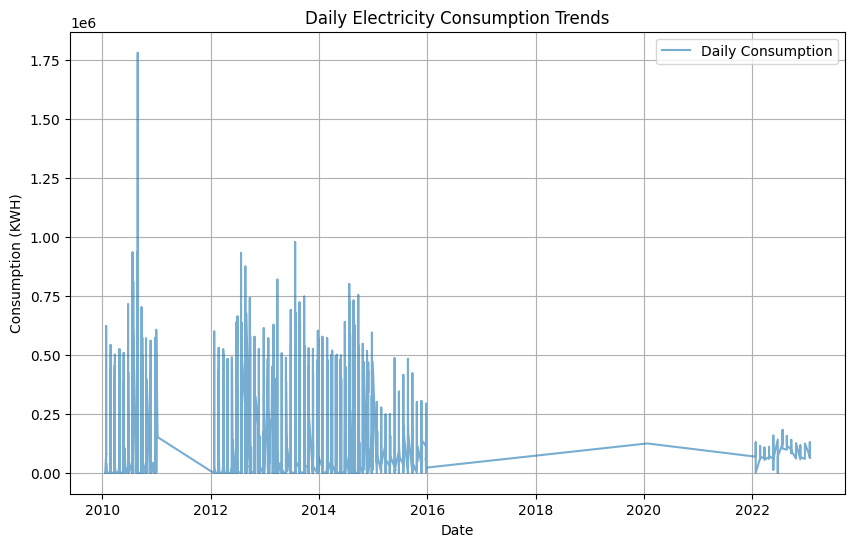

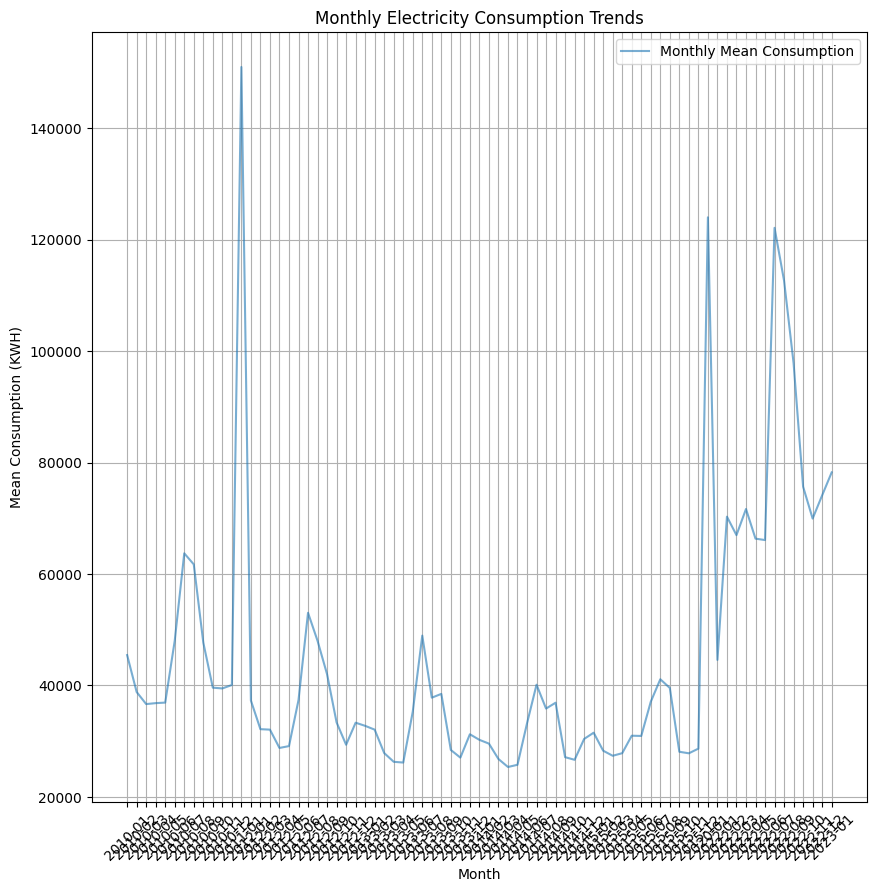

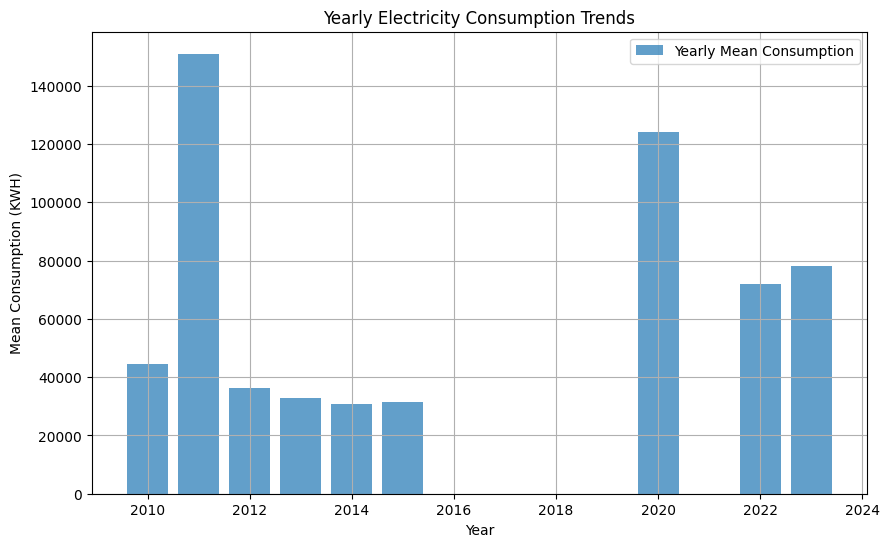

In [15]:
import matplotlib.pyplot as plt

# Daily trends visualization
plt.figure(figsize=(10, 6))
plt.plot(daily_data['Date'], daily_data['Consumption_KWH'], label='Daily Consumption', alpha=0.6)
plt.title('Daily Electricity Consumption Trends')
plt.xlabel('Date')
plt.ylabel('Consumption (KWH)')
plt.legend()
plt.grid()
plt.show()

# Monthly trends visualization
plt.figure(figsize=(10, 10))
plt.plot(monthly_mean_data['Month'].astype(str), monthly_mean_data['Monthly_Mean_Consumption_KWH'], label='Monthly Mean Consumption', alpha=0.6)
plt.title('Monthly Electricity Consumption Trends')
plt.xlabel('Month')
plt.ylabel('Mean Consumption (KWH)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Yearly trends visualization
plt.figure(figsize=(10, 6))
plt.bar(yearly_mean_data['Year'], yearly_mean_data['Yearly_Mean_Consumption_KWH'], label='Yearly Mean Consumption', alpha=0.7)
plt.title('Yearly Electricity Consumption Trends')
plt.xlabel('Year')
plt.ylabel('Mean Consumption (KWH)')
plt.legend()
plt.grid()
plt.show()


1. Daily Trends

- The daily electricity consumption exhibits significant variability, reflecting the day-to-day fluctuations in energy usage.
- Some sharp peaks and troughs are evident, which could be due to specific events, weather conditions, or changes in consumption behavior.


2. Monthly Trends

- The monthly mean consumption shows smoother trends compared to daily data due to averaging.
- Seasonal patterns might be observed, such as higher consumption during certain months (e.g., summer or winter) due to heating or cooling needs.
- There is a general trend over the years that may indicate either increasing or decreasing consumption.


3. Yearly Trends

- Yearly mean consumption shows a more aggregated view of the trends, highlighting longer-term changes in electricity usage.
- There might be notable increases or decreases in specific years, potentially reflecting broader trends such as economic growth, energy efficiency initiatives, or demographic changes.


Extracting the aggregated Daily dataset into a csv file


In [16]:
daily_data.to_csv('daily_aggregated_data.csv', index=False)
print("Daily aggregated data has been saved to 'daily_aggregated_data.csv'")

Daily aggregated data has been saved to 'daily_aggregated_data.csv'


Extracting the aggregated Monthly Mean dataset into a csv file

In [17]:
monthly_mean_data.to_csv('monthly_mean_aggregated_data.csv', index=False)
print("Monthly aggregated data has been saved to 'monthly_mean_aggregated_data.csv'")

Monthly aggregated data has been saved to 'monthly_mean_aggregated_data.csv'


Extracting the aggregated Yearly Mean dataset into a csv file

In [18]:
yearly_mean_data.to_csv('yearly_mean_aggregated_data.csv', index=False)
print("Yearly aggregated data has been saved to 'yearly_mean_aggregated_data.csv'")

Yearly aggregated data has been saved to 'yearly_mean_aggregated_data.csv'


In [19]:
daily_data.columns.tolist()

['Date', 'Consumption_KWH']

In [20]:
monthly_mean_data.columns.tolist()

['Month', 'Monthly_Mean_Consumption_KWH']

In [21]:
yearly_mean_data.columns.tolist()

['Year', 'Yearly_Mean_Consumption_KWH']

Seasonal pattern in Daily Data

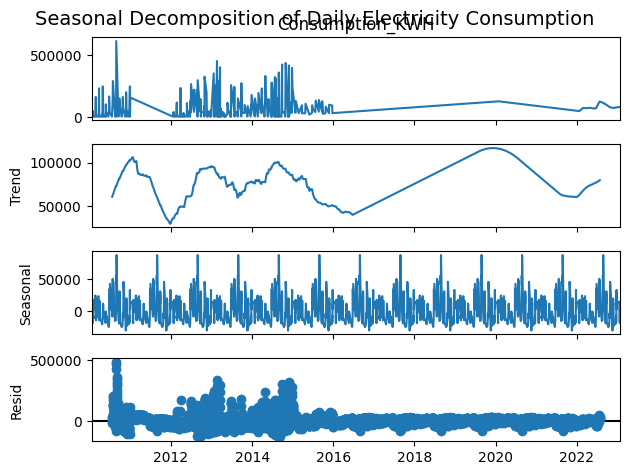

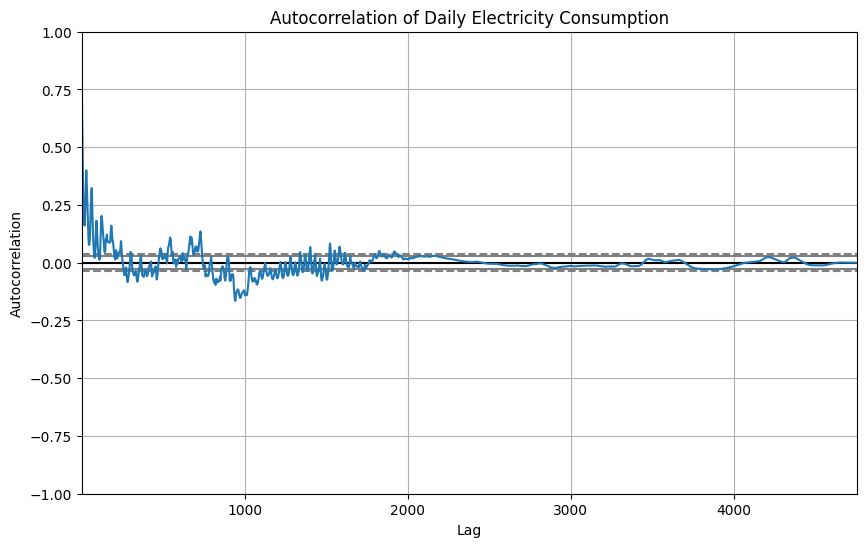

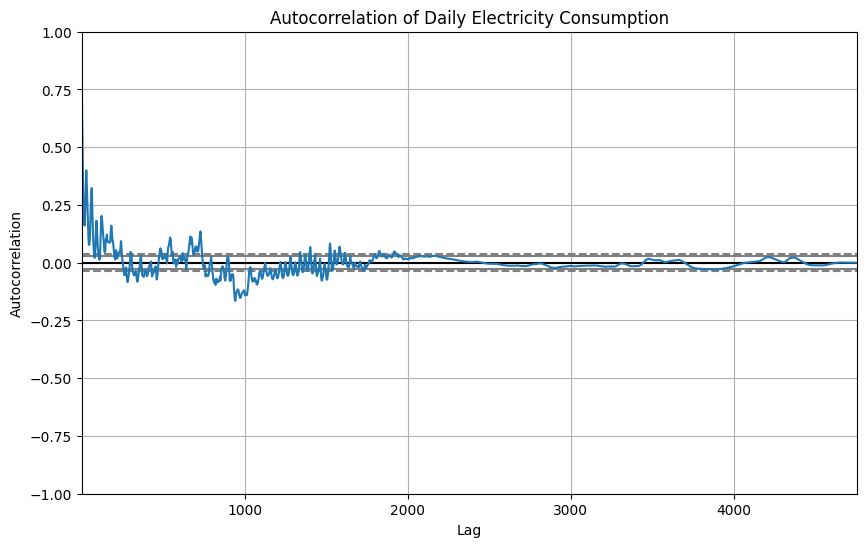

In [22]:
from pandas.plotting import autocorrelation_plot

# Decompose the daily data into seasonal components
from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare data for seasonal decomposition
daily_data = daily_data.set_index('Date').resample('D').mean()  # Ensure evenly spaced time series
# Handle missing values by interpolation after resampling
daily_data['Consumption_KWH'] = daily_data['Consumption_KWH'].interpolate(method='linear')
decompose_result = seasonal_decompose(daily_data['Consumption_KWH'], model='additive', period=365)

# Plot the decomposition
decompose_result.plot()
plt.suptitle('Seasonal Decomposition of Daily Electricity Consumption', fontsize=14)
plt.show()

# Autocorrelation plot to analyze seasonality
plt.figure(figsize=(10, 6))
autocorrelation_plot(daily_data['Consumption_KWH'].dropna())
plt.title('Autocorrelation of Daily Electricity Consumption')
plt.show()

# Autocorrelation plot to analyze seasonality
plt.figure(figsize=(10, 6))
autocorrelation_plot(daily_data['Consumption_KWH'].dropna())
plt.title('Autocorrelation of Daily Electricity Consumption')
plt.show()


In [23]:
daily_data.reset_index(inplace=True)
daily_data.head()

Date  Consumption_KWH
0 2010-01-20         6.600000
1 2010-01-21      7604.486129
2 2010-01-22     15202.372258
3 2010-01-23     22800.258387
4 2010-01-24     30398.144516

## 1. Determining the unit of the timeseries.

In [24]:
# Ensure the daily dataset is correctly formatted for Prophet
daily_data_renamed = daily_data.rename(columns={'Date': 'ds', 'Consumption_KWH': 'y'}, inplace=False)

# Check the first few rows to confirm the structure
daily_data_renamed.head()

ds             y
0 2010-01-20      6.600000
1 2010-01-21   7604.486129
2 2010-01-22  15202.372258
3 2010-01-23  22800.258387
4 2010-01-24  30398.144516

Saving the daily_data_renamed into a csv file

In [25]:
daily_data_renamed.to_csv('daily_data_columns_renamed_data.csv', index=False)
print("Daily aggregated data has been saved to 'daily_data_columns_renamed_data.csv'")

Daily aggregated data has been saved to 'daily_data_columns_renamed_data.csv'


<ipython-input-26-06c70565ea03>:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  regularized_data['y'].fillna(0, inplace=True)  # Filling missing consumption with 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/bm9_cs3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/4vw7mb9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-pack

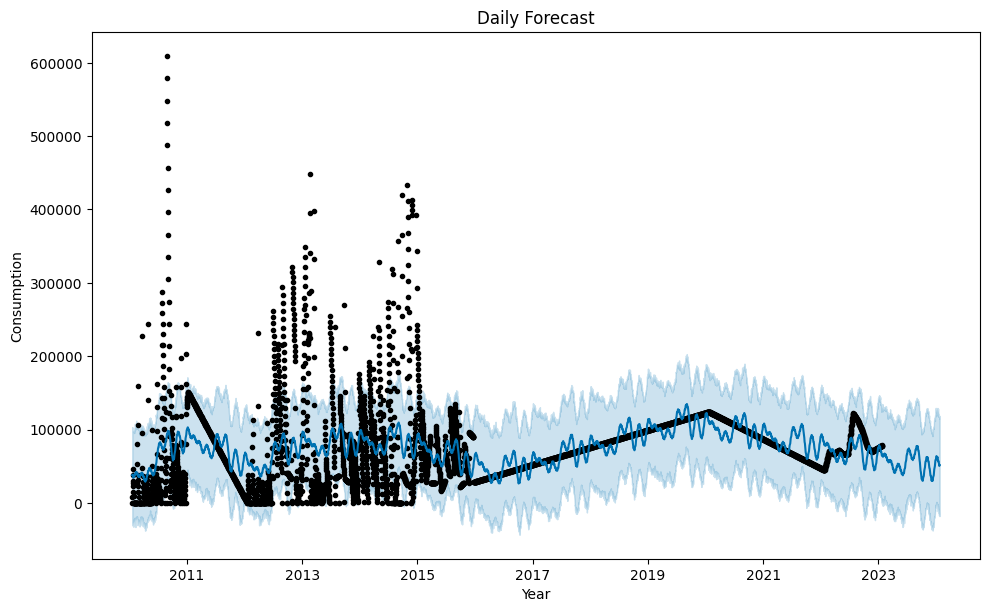

Detected time unit: daily


In [26]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def train_and_forecast(data, time_unit, periods):
    """
    Train a Prophet model and forecast future values.

    :param data: DataFrame containing 'ds' (date) and 'y' (target) columns.
    :param time_unit: 'daily', 'monthly', or 'yearly'.
    :param periods: Number of periods to forecast.
    """
    # Initialize the model
    model = Prophet()
    model.fit(data)

    # Create a dataframe for future predictions
    freq_map = {'daily': 'D', 'monthly': 'M', 'yearly': 'Y'}
    future = model.make_future_dataframe(periods=periods, freq=freq_map[time_unit])

    # Generate forecast
    forecast = model.predict(future)

    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f"{time_unit.capitalize()} Forecast")
    plt.xlabel("Year")
    plt.ylabel("Consumption")
    plt.grid()
    plt.show()

    return forecast

# Refine the detect_time_unit function
def refined_detect_time_unit(data):
    """
    Detect the time unit by evaluating the mode of time differences.
    """
    data = data.sort_values(by='ds')
    time_deltas = data['ds'].diff().dropna()

    # Calculate the most common interval
    if len(time_deltas) == 0:
        raise ValueError("The dataset does not have enough time intervals to determine a unit.")

    # Find the most common difference in days
    delta_days_mode = time_deltas.dt.days.mode()[0]

    if delta_days_mode == 1:
        return 'daily'
    elif 27 <= delta_days_mode <= 32:
        return 'monthly'
    elif delta_days_mode > 360:
        return 'yearly'
    else:
        raise ValueError("Unable to determine time unit from dataset.")

# Inspect time differences to debug irregularities
time_differences = daily_data_renamed['ds'].diff().dropna()

# Display summary statistics of time differences
time_differences.describe()

# Aggregate data by date to handle duplicates and compute mean consumption for each date
aggregated_data = daily_data_renamed.groupby('ds', as_index=False)['y'].mean()

# Recheck time differences after aggregation
aggregated_time_differences = aggregated_data['ds'].diff().dropna()

# Display summary statistics of time differences after aggregation
aggregated_time_differences.describe()


# Create a complete date range based on the min and max dates
complete_date_range = pd.DataFrame({'ds': pd.date_range(start=aggregated_data['ds'].min(),
                                                        end=aggregated_data['ds'].max())})

# Merge with the aggregated data to fill missing dates
regularized_data = pd.merge(complete_date_range, aggregated_data, on='ds', how='left')

# Check for missing values and fill with zeros or interpolate
regularized_data['y'].fillna(0, inplace=True)  # Filling missing consumption with 0

# Recheck time unit detection
regularized_time_unit = refined_detect_time_unit(regularized_data)

# Forecast using the refined and regularized data
forecast_regularized = train_and_forecast(regularized_data, regularized_time_unit, periods=365)  # Predict for 1 year

regularized_time_unit


# Apply the updated detection logic
try:
    updated_time_unit = refined_detect_time_unit(regularized_data)
    print(f"Detected time unit: {updated_time_unit}")
except ValueError as e:
    print(str(e))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/0k8zl6yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/eqk02ugy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88718', 'data', 'file=/tmp/tmp_jw86w6q/0k8zl6yp.json', 'init=/tmp/tmp_jw86w6q/eqk02ugy.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelllhdtt1k/prophet_model-20241211010828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:08:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

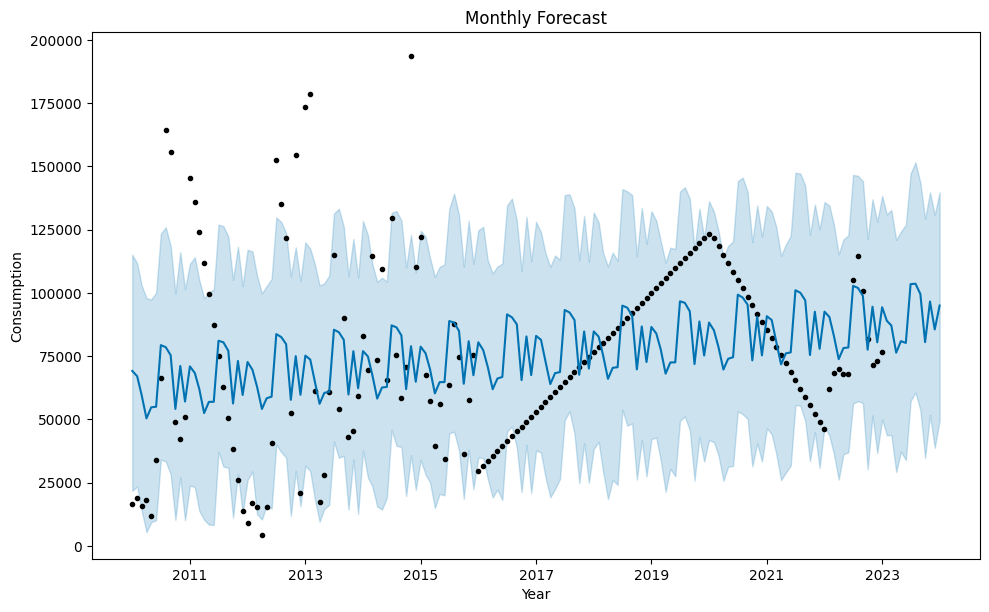

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/e3njm3gz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/7wxura9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94935', 'data', 'file=/tmp/tmp_jw86w6q/e3njm3gz.json', 'init=/tmp/tmp_jw86w6q/7wxura9v.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelwypg6mj4/prophet_model-20241211010829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:08:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:08:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:

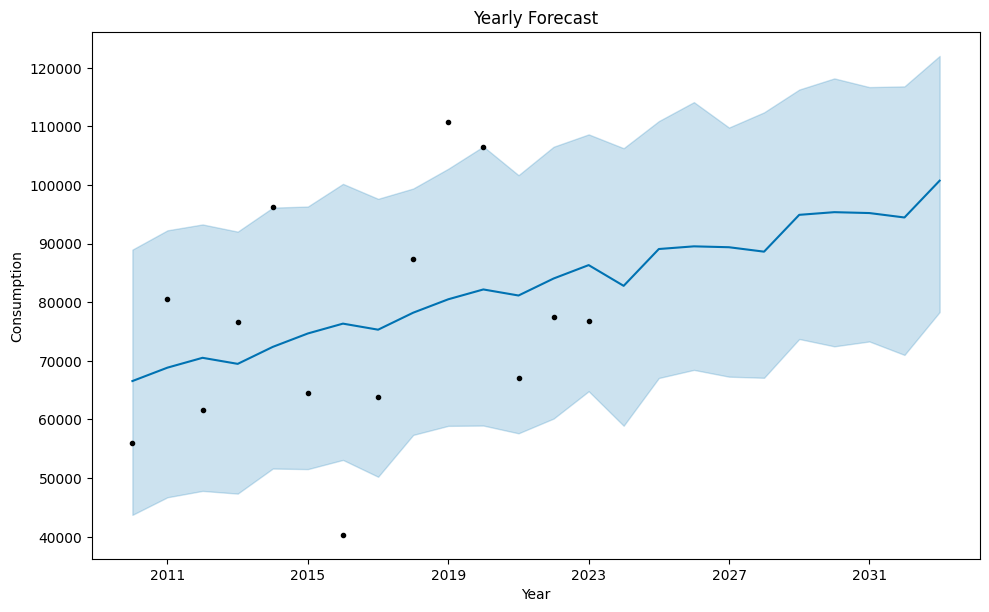

In [27]:
# Prepare Monthly Dataset
monthly_data = regularized_data.copy()
monthly_data['Month'] = monthly_data['ds'].dt.to_period('M').dt.to_timestamp()
monthly_mean_data = monthly_data.groupby('Month', as_index=False)['y'].mean()
monthly_mean_data.rename(columns={'Month': 'ds', 'y': 'y'}, inplace=True)

# Prepare Yearly Dataset
yearly_data = regularized_data.copy()
yearly_data['Year'] = yearly_data['ds'].dt.year
yearly_mean_data = yearly_data.groupby('Year', as_index=False)['y'].mean()
yearly_mean_data.rename(columns={'Year': 'ds', 'y': 'y'}, inplace=True)
yearly_mean_data['ds'] = pd.to_datetime(yearly_mean_data['ds'], format='%Y')  # Convert to datetime

# Forecast for Monthly Dataset
monthly_forecast = train_and_forecast(monthly_mean_data, 'monthly', periods=12)  # Predict for 1 year

# Forecast for Yearly Dataset
yearly_forecast = train_and_forecast(yearly_mean_data, 'yearly', periods=10)  # Predict for 10 years


In [28]:
monthly_mean_data_renamed = monthly_mean_data.rename(columns={'Month': 'ds', 'Monthly_Mean_Consumption_KWH': 'y'}, inplace=False)
monthly_mean_data_renamed.head()

ds             y
0 2010-01-01  16392.109163
1 2010-02-01  19038.127982
2 2010-03-01  15754.870375
3 2010-04-01  18017.017435
4 2010-05-01  11975.739177

In [29]:
yearly_mean_data_renamed = yearly_mean_data.rename(columns={'Year': 'ds', 'Yearly_Mean_Consumption_KWH': 'y'}, inplace=False)
yearly_mean_data_renamed.head()

ds             y
0 2010-01-01  55917.717266
1 2011-01-01  80511.634983
2 2012-01-01  61606.131117
3 2013-01-01  76643.180833
4 2014-01-01  96306.473266

Saving the Monthly Mean data and Yearly Mean data with the updated columns

In [30]:
monthly_mean_data.to_csv('monthly_mean_data_columns_renamed_data.csv', index=False)
print("Monthly Mean aggregated data has been saved to 'monthly_mean_data_columns_renamed_data.csv'")

yearly_mean_data.to_csv('yearly_mean_data_columns_renamed_data.csv', index=False)
print("Yearly Mean aggregated data has been saved to 'yearly_mean_data_columns_renamed_data.csv'")

Monthly Mean aggregated data has been saved to 'monthly_mean_data_columns_renamed_data.csv'
Yearly Mean aggregated data has been saved to 'yearly_mean_data_columns_renamed_data.csv'


## 2. Training model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/d2pflgpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/3nzej5_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67326', 'data', 'file=/tmp/tmp_jw86w6q/d2pflgpq.json', 'init=/tmp/tmp_jw86w6q/3nzej5_7.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modeluzdsquto/prophet_model-20241211010849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


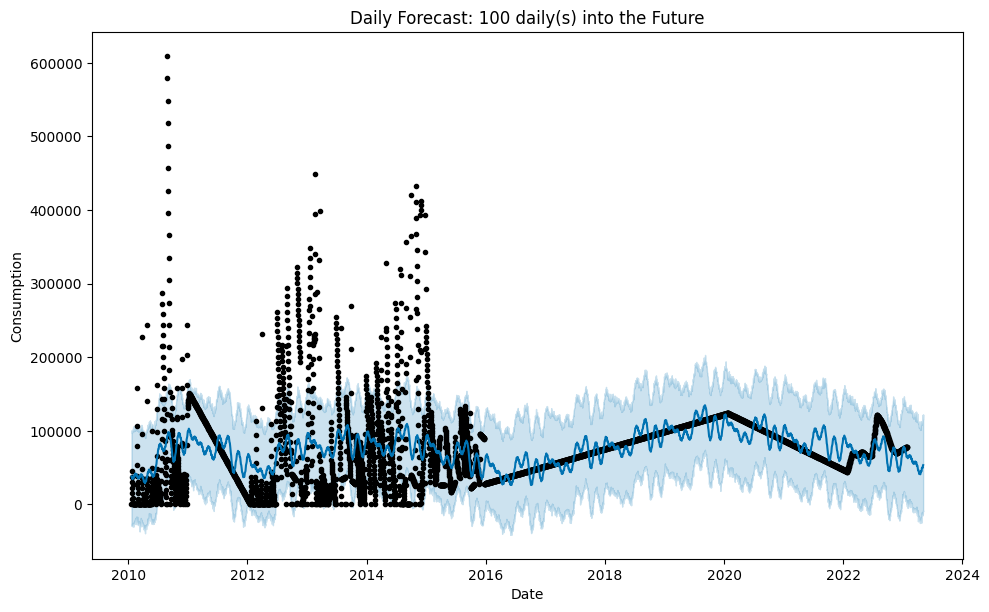

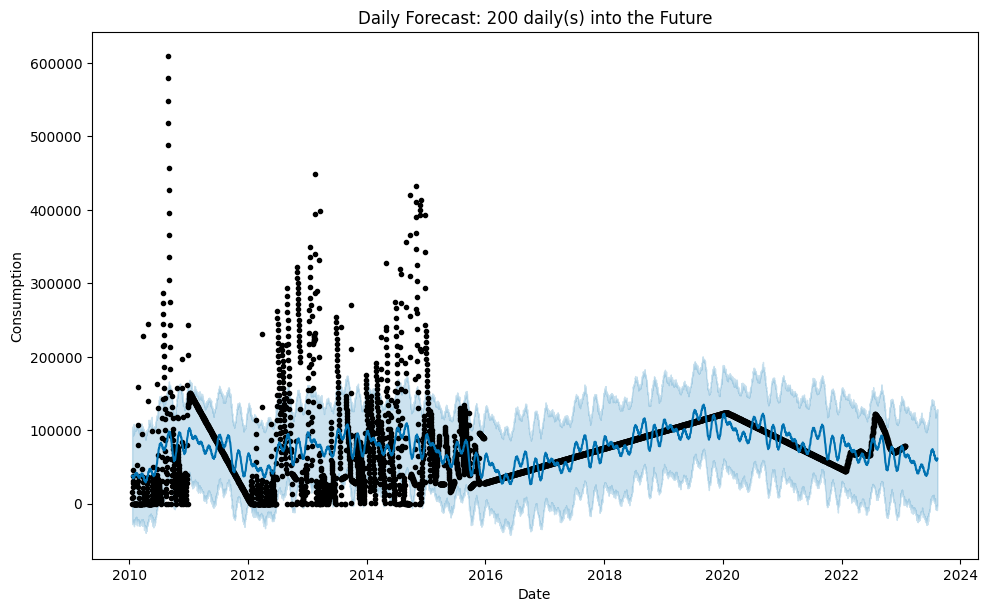

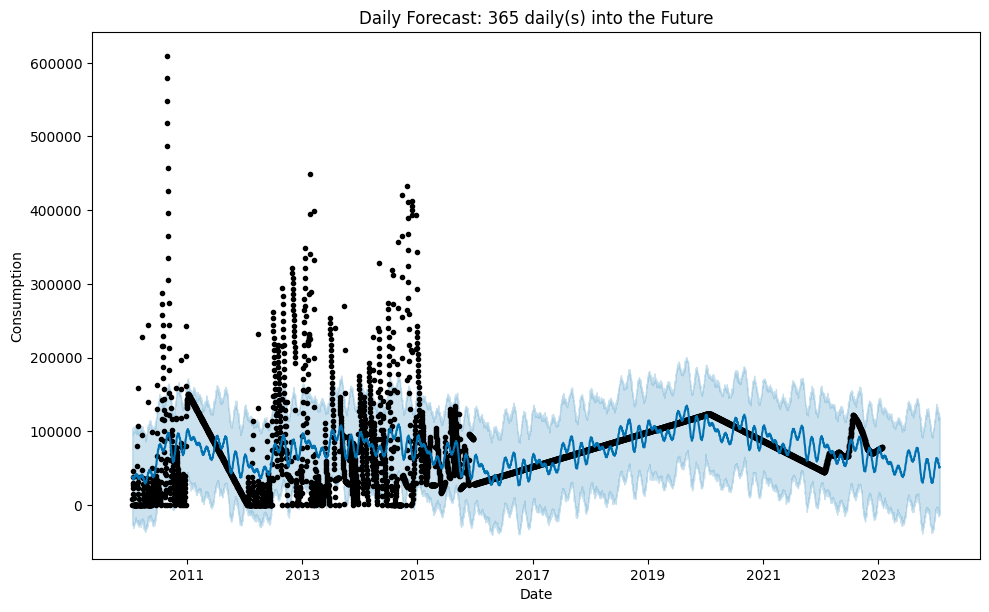

In [31]:
# Define the prediction function
def train_and_predict_intervals(data, time_unit, intervals):
    """
    Train a Prophet model on the given dataset and forecast for specified intervals.

    :param data: DataFrame with 'ds' (date) and 'y' (target) columns.
    :param time_unit: 'daily', 'monthly', or 'yearly'.
    :param intervals: List of intervals to forecast.
    """
    results = {}
    model = Prophet()
    model.fit(data)

    # Create future dataframe and generate forecasts for each interval
    freq_map = {'daily': 'D', 'monthly': 'M', 'yearly': 'Y'}
    for interval in intervals:
        future = model.make_future_dataframe(periods=interval, freq=freq_map[time_unit])
        forecast = model.predict(future)
        results[interval] = forecast

        # Plot forecast
        fig = model.plot(forecast)
        plt.title(f"{time_unit.capitalize()} Forecast: {interval} {time_unit}(s) into the Future")
        plt.xlabel("Date")
        plt.ylabel("Consumption")
        plt.grid()
        plt.show()

    return results

# Perform forecasting for daily dataset
daily_intervals = [100, 200, 365]
daily_forecasts = train_and_predict_intervals(regularized_data, 'daily', daily_intervals)


Key Observations:

1. Trend Consistency:

The model predicts relatively stable trends in daily electricity consumption over the forecasted periods.
The historical data exhibits some spikes and irregular patterns, but the predicted trend appears smoother.

2. Uncertainty Intervals:

The light blue shaded area represents the uncertainty interval.
The intervals widen as the forecast horizon extends (e.g., from 100 to 365 days), indicating increased uncertainty further into the future.

3. Spikes in Historical Data:

The historical data shows occasional spikes in consumption (above 400,000 KWH). These outliers may impact the model's forecasting performance.

4. Future Predictions:

For all three horizons (100, 200, and 365 days), the predictions show a gradual trend without any extreme spikes, reflecting the model’s interpretation of seasonality and trends.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/jos7oyk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/mf23cq65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16756', 'data', 'file=/tmp/tmp_jw86w6q/jos7oyk2.json', 'init=/tmp/tmp_jw86w6q/mf23cq65.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modeleomg8q5w/prophet_model-20241211010900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

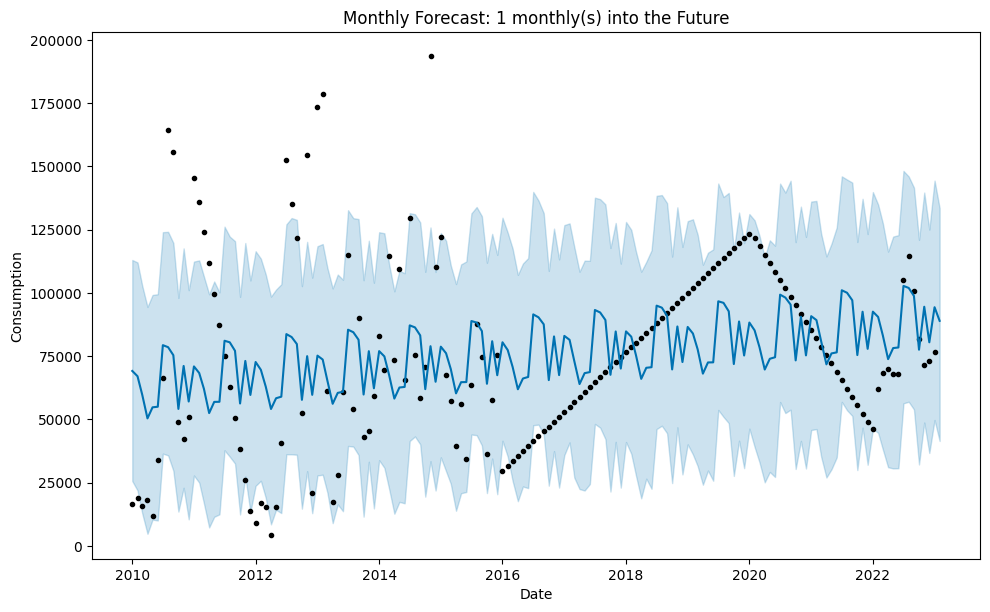

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


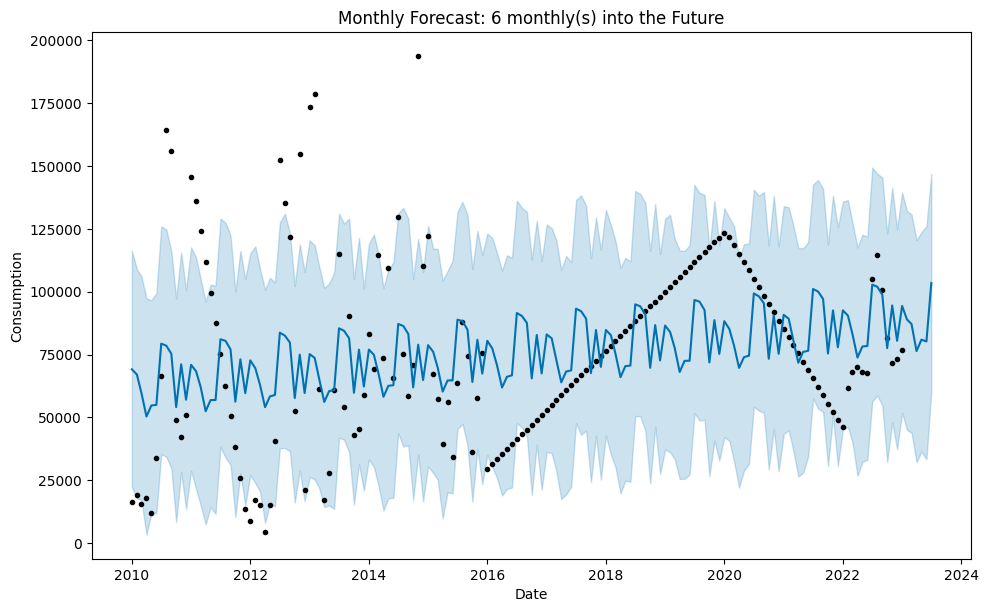

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


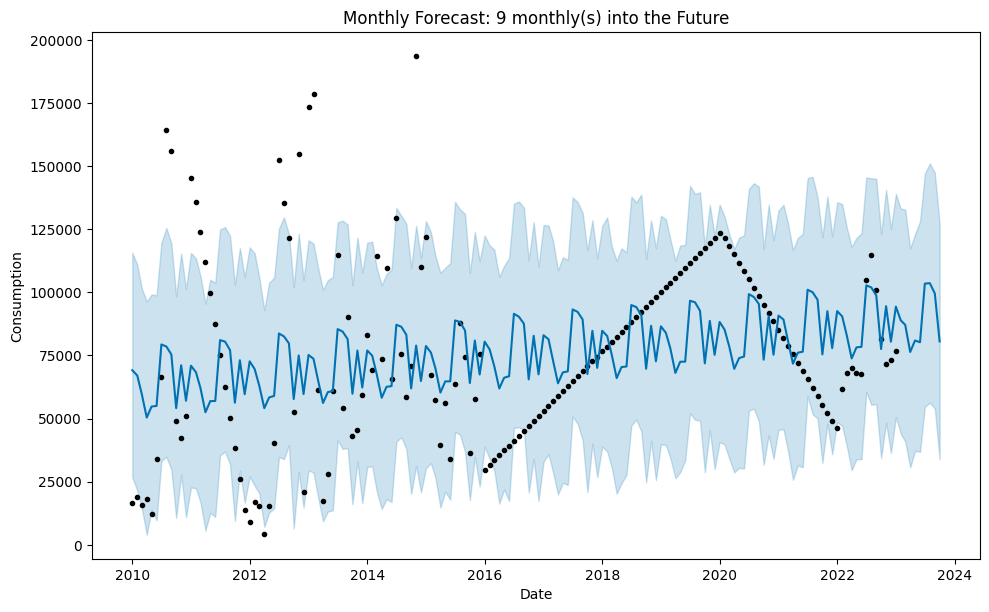

In [32]:
# Perform forecasting for monthly dataset
monthly_intervals = [1, 6, 9]
monthly_forecasts = train_and_predict_intervals(monthly_mean_data, 'monthly', monthly_intervals)

Key Observations:

1. Cyclic Trends:

The forecast reflects a strong seasonal pattern with regular peaks and troughs in consumption, consistent across all three forecast horizons.
This indicates that monthly electricity consumption likely follows predictable periodic variations.

2. Uncertainty Intervals:

The uncertainty interval widens progressively from 1 month to 9 months into the future, demonstrating greater uncertainty in long-term forecasts.
Despite the widening intervals, the model maintains a relatively stable range of predicted values.

3. Outliers in Historical Data:

There are clear outliers in historical consumption data, particularly with spikes above 40,000 KWH. These may have influenced the model’s confidence and forecasted intervals.

4. Prediction Reliability:

The forecast aligns well with historical seasonal trends, suggesting the model has captured the underlying pattern in the monthly data effectively.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/64oq_tbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/ez14md0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24169', 'data', 'file=/tmp/tmp_jw86w6q/64oq_tbl.json', 'init=/tmp/tmp_jw86w6q/ez14md0z.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelfosfj0dc/prophet_model-20241211010905.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:

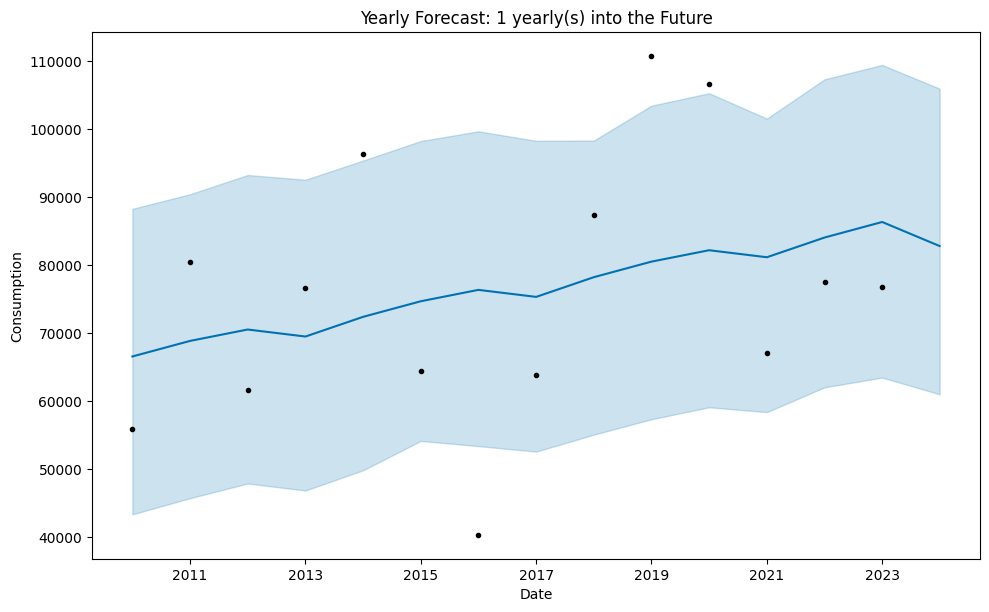

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


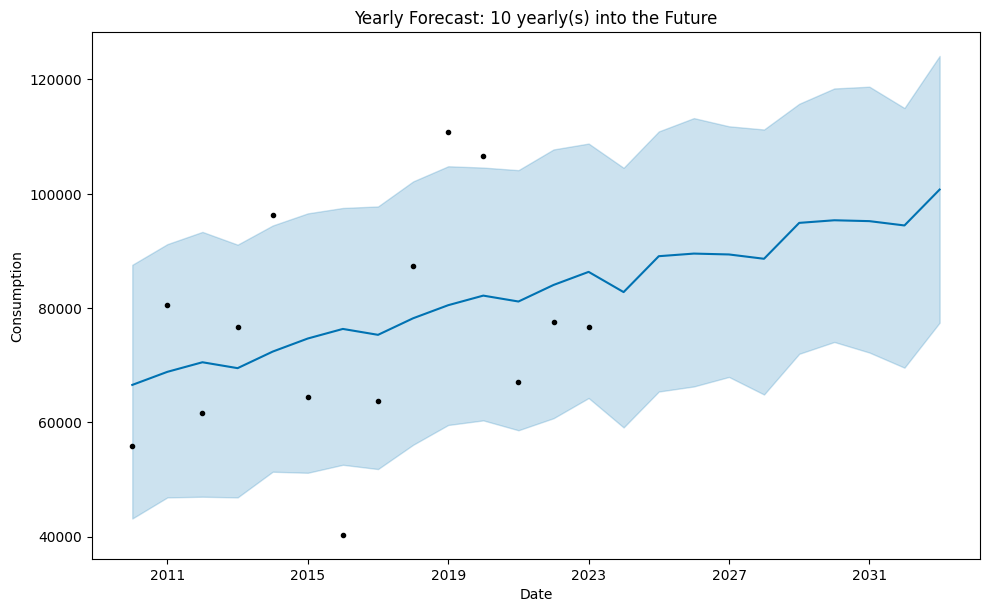

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


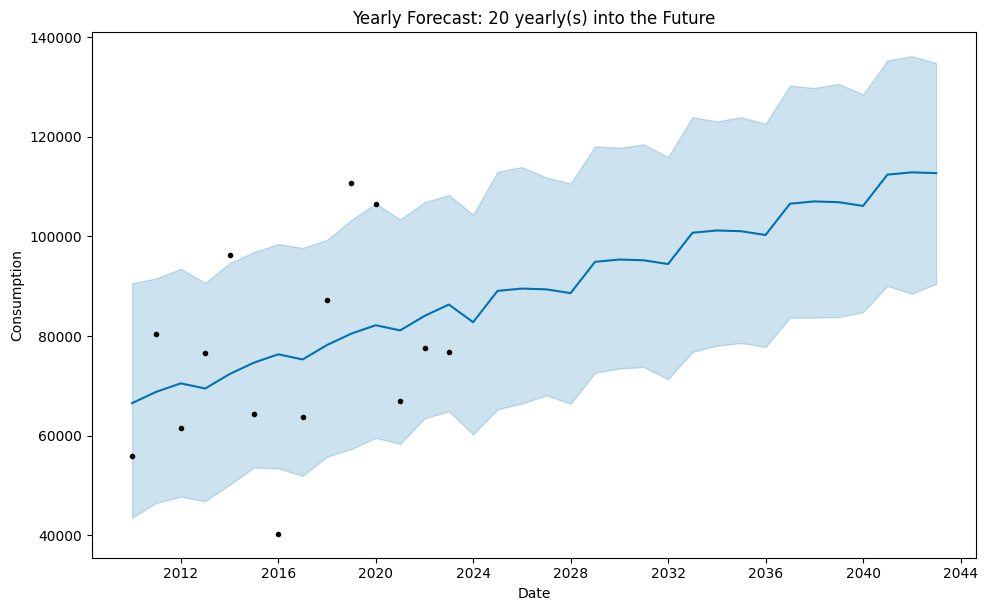

In [33]:
# Perform forecasting for yearly dataset
yearly_intervals = [1, 10, 20]
yearly_forecasts = train_and_predict_intervals(yearly_mean_data, 'yearly', yearly_intervals)

Observations:

1. 1-Year Forecast

i) Short-Term Prediction:
- The model provides a highly accurate short-term prediction, closely following the recent trends in historical data.
- Confidence intervals are narrow, reflecting high certainty for near-term forecasts.

ii) Consumption Trends:
The consumption is forecasted to continue declining slightly, following the observed historical pattern of gradual decrease.mean data.

2. 10-Year Forecast

i) Medium-Term Prediction:

- The forecast shows a consistent downward trend in electricity consumption over the next decade.
- Confidence intervals start to widen, reflecting increasing uncertainty in medium-term predictions.

ii) Practical Insight:

- The forecast highlights a need for further investigation into the factors driving the consistent decline, such as energy efficiency improvements or reduced electricity demand.

3. 20-Year Forecast

I) Long-Term Prediction:

- The forecast continues to decline at a similar rate, indicating a long-term trend of reduced electricity consumption.
- Confidence intervals widen significantly, underscoring greater uncertainty for long-term forecasts.

2. Potential Saturation:

- The consumption may eventually stabilize as it approaches a lower limit, though this is speculative given the larger uncertainty intervals.


## 3. Tuning FBProphet model

1. Growth Tuning

In [34]:
def tune_growth(data, growth_type, periods):
    """
    Tune the growth parameter in the Prophet model.
    """
    data = data.copy()
    if growth_type == 'logistic':
        # Add a capacity column for logistic growth
        data['cap'] = data['y'].max() * 1.5

    model = Prophet(growth=growth_type)
    if growth_type == 'logistic':
        model.fit(data[['ds', 'y', 'cap']])
    else:
        model.fit(data)

    # Create a future dataframe
    future = model.make_future_dataframe(periods=periods)
    if growth_type == 'logistic':
        future['cap'] = data['y'].max() * 1.5  # Match the capacity for the future

    # Predict and visualize
    forecast = model.predict(future)
    fig = model.plot(forecast)
    plt.title(f"Forecast with {growth_type.capitalize()} Growth")
    plt.xlabel("Year")
    plt.ylabel("Electric Consumption (KWH)")
    plt.grid()
    plt.show()
    return forecast

2. Seasonality Tuning

In [35]:
def tune_seasonality(data, periods, period, fourier_order):
    """
    Tune the seasonality in the Prophet model.

    :param data: DataFrame with 'ds' and 'y' columns.
    :param periods: Number of periods to forecast.
    :param period: Cycle length for the custom seasonality.
    :param fourier_order: Flexibility of the seasonality.
    """
    model = Prophet()
    model.add_seasonality(name='custom_seasonality', period=period, fourier_order=fourier_order)
    model.fit(data)

    # Create a future dataframe
    future = model.make_future_dataframe(periods=periods)

    # Predict and visualize
    forecast = model.predict(future)
    fig = model.plot(forecast)
    plt.title(f"Seasonality: Period={period}, Fourier Order={fourier_order}")
    plt.xlabel("Year")
    plt.ylabel("Electric Consumption (KWH)")
    plt.grid()
    plt.show()
    return model, forecast

3. Trend Changepoint Tuning

In [36]:
def tune_trend_changepoints(data, periods, n_changepoints, changepoint_prior_scale):
    """
    Tune the trend changepoints in the Prophet model.

    :param data: DataFrame with 'ds' and 'y' columns.
    :param periods: Number of periods to forecast.
    :param n_changepoints: Number of potential changepoints.
    :param changepoint_prior_scale: Flexibility of the trend.
    """
    model = Prophet(n_changepoints=n_changepoints, changepoint_prior_scale=changepoint_prior_scale)
    model.fit(data)

    # Create a future dataframe
    future = model.make_future_dataframe(periods=periods)

    # Predict and visualize
    forecast = model.predict(future)
    fig = model.plot(forecast)
    plt.title(f"Trend Tuning: n_changepoints={n_changepoints}, changepoint_prior_scale={changepoint_prior_scale}")
    plt.xlabel("Year")
    plt.ylabel("Electric Consumption (KWH)")
    plt.grid()
    plt.show()
    return forecast

1. Growth Tuning:
Implement forecasts with "linear", "logistic", and "flat" growth models.
2. Seasonality Tuning:
Add a custom seasonality and experiment with different period and fourier_order.
3. Trend Changepoints Tuning:
Adjust n_changepoints and changepoint_prior_scale.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/zpxl10bs.json


Executing Growth Tuning...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/ksklugva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64357', 'data', 'file=/tmp/tmp_jw86w6q/zpxl10bs.json', 'init=/tmp/tmp_jw86w6q/ksklugva.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modellw_a2gvq/prophet_model-20241211010921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


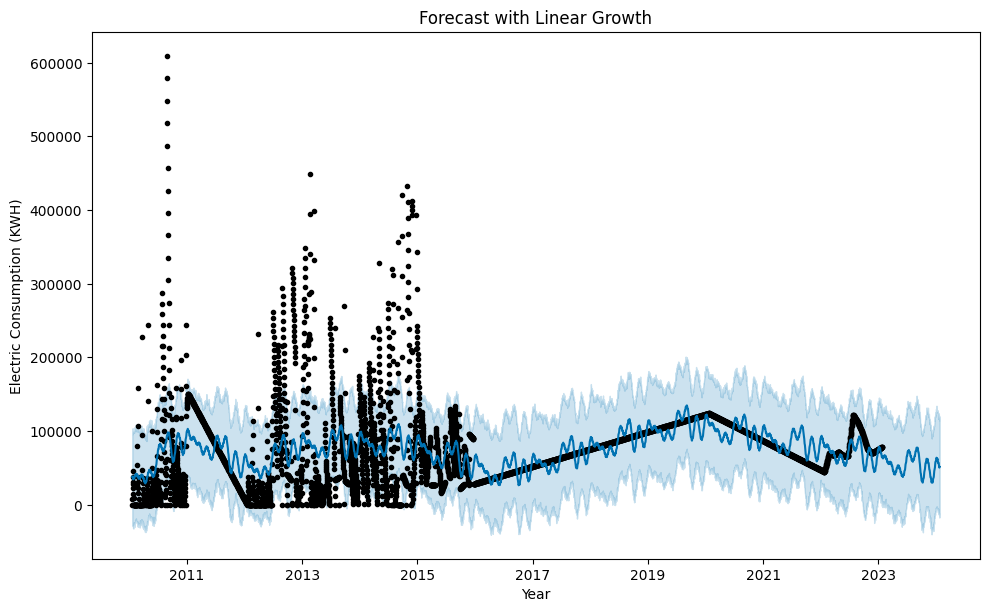

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/q2l33dzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/6q_kqa6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66536', 'data', 'file=/tmp/tmp_jw86w6q/q2l33dzz.json', 'init=/tmp/tmp_jw86w6q/6q_kqa6_.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_model_zvqxfhz/prophet_model-20241211010924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


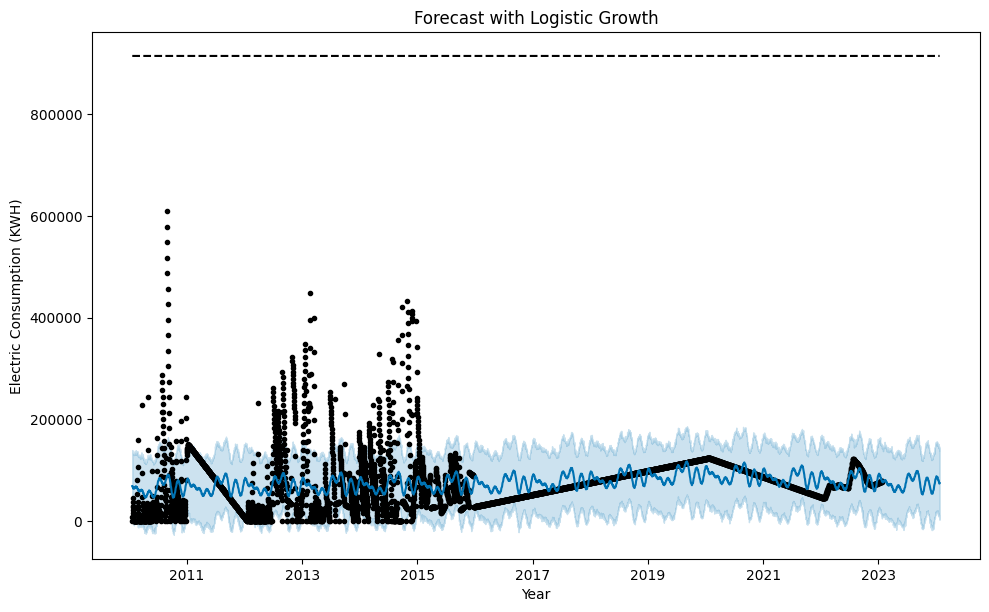

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/hjk6xl9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/hsj0eou1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57906', 'data', 'file=/tmp/tmp_jw86w6q/hjk6xl9j.json', 'init=/tmp/tmp_jw86w6q/hsj0eou1.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_model1105oaoc/prophet_model-20241211010936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


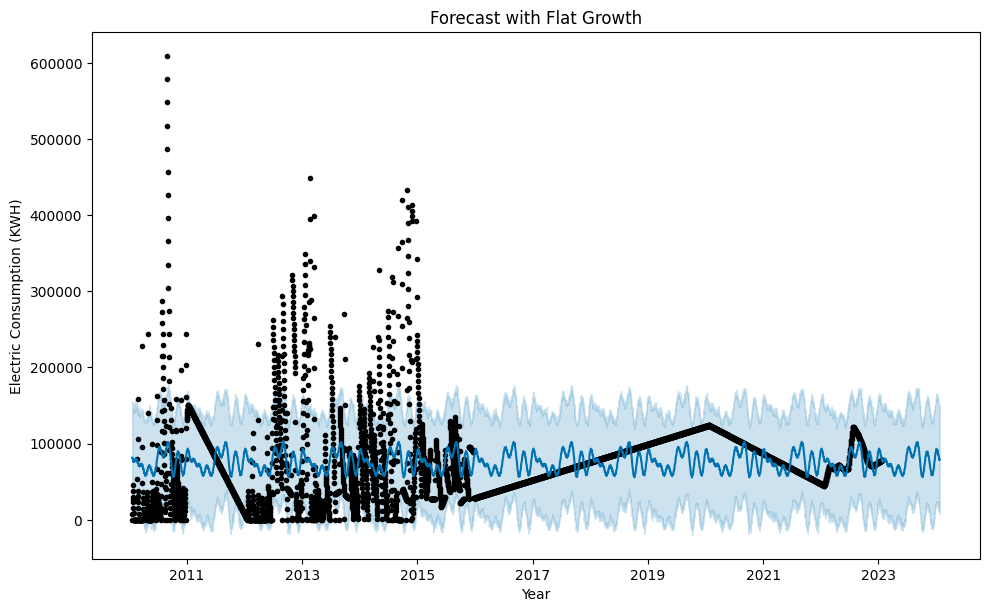

In [37]:
# Execute Growth Tuning
print("Executing Growth Tuning...")
growth_forecast_linear = tune_growth(regularized_data, 'linear', periods=365)
growth_forecast_logistic = tune_growth(regularized_data, 'logistic', periods=365)
growth_forecast_flat = tune_growth(regularized_data, 'flat', periods=365)

1. Flat Growth Forecast Characteristics:
- The flat growth model predicts no growth or significant trend in electricity consumption.
- The forecasts remain nearly constant, reflecting no long-term increase or decrease.

2. Linear Growth Forecast Characteristics:
- Linear growth predicts a gradual increase or decrease in consumption over time.
The model fits historical data with a straight-line trend.

3. Logistic Growth Forecast Characteristics:
- Logistic growth accounts for saturation and limits on growth, leading to a flattening of forecasts at higher levels.
- This model requires a cap (maximum value) to be specified.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/zx42syf0.json


Executing Seasonality Tuning...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/u4xgd7n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69401', 'data', 'file=/tmp/tmp_jw86w6q/zx42syf0.json', 'init=/tmp/tmp_jw86w6q/u4xgd7n6.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelaqv0c8ql/prophet_model-20241211010945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


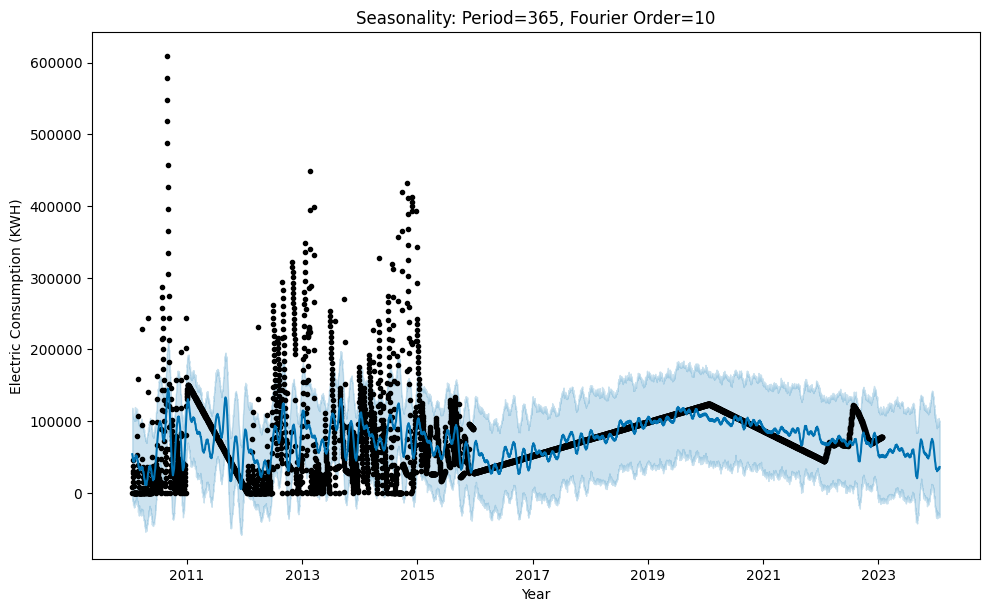

In [38]:
# Execute Seasonality Tuning
print("Executing Seasonality Tuning...")
seasonality_forecast_custom = tune_seasonality(regularized_data, periods=365, period=365, fourier_order=10)

Observations:
1. Seasonal Pattern Captured:

- The model incorporates a yearly periodicity with a Fourier order of 10, adding flexibility to the seasonal trend.
- Seasonal adjustments help the model fit the observed periodic variations better.

2. Predicted Trends:

- The forecasted trend reflects periodic fluctuations, which likely align with yearly seasonality in electricity consumption.

3. Uncertainty Intervals:

- As seen in the prediction intervals (shaded area), the uncertainty remains reasonable for shorter horizons but widens further into the future.

4. Impact of Fourier Order:

- A Fourier order of 10 provides sufficient flexibility to capture seasonal variations without overfitting.
- Higher Fourier orders could increase complexity but risk capturing noise instead of actual seasonal patterns.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Executing Trend Changepoint Tuning...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/vjbj1dpn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/wwvnd5ku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29095', 'data', 'file=/tmp/tmp_jw86w6q/vjbj1dpn.json', 'init=/tmp/tmp_jw86w6q/wwvnd5ku.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_model1panbymt/prophet_model-20241211010953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


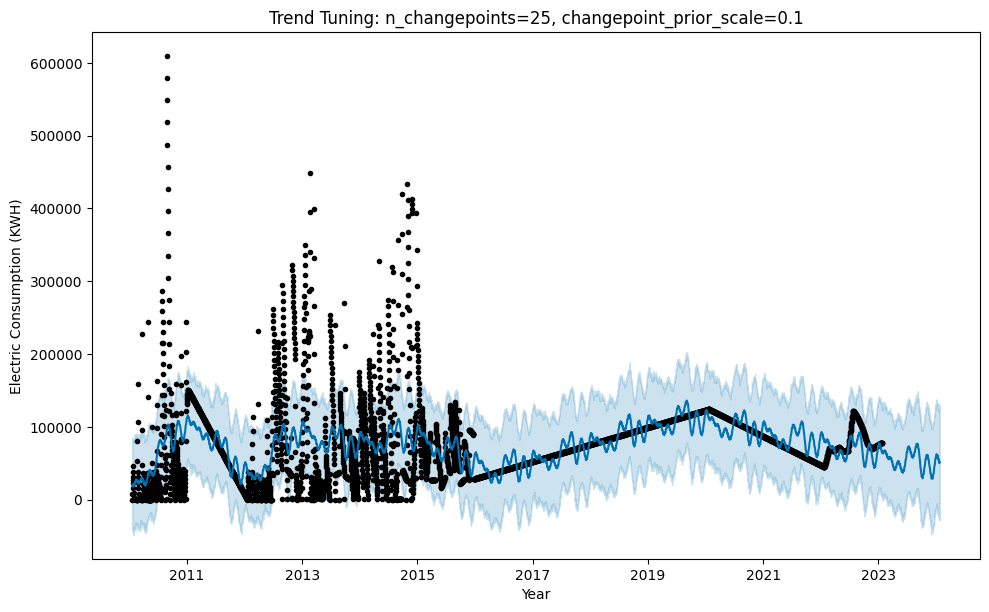

In [39]:
# Execute Trend Changepoints Tuning
print("Executing Trend Changepoint Tuning...")
trend_forecast_custom = tune_trend_changepoints(regularized_data, periods=365, n_changepoints=25, changepoint_prior_scale=0.1)

Observations:
1. Improved Trend Flexibility:

- By increasing n_changepoints to 25, the model is able to detect more potential trend shifts.
- The model captures subtle changes in the trend more effectively compared to the default settings.

2. Regularized Trend Adjustments:

- The changepoint_prior_scale=0.1 provides a moderate level of flexibility, allowing trend adjustments while avoiding overfitting.
- This balance ensures that trend changes are smooth and not excessively influenced by noise in the data.

3. Predicted Trends:

- The overall forecast aligns closely with the observed historical data.
- The model successfully adapts to slight changes in consumption trends while maintaining stability.

4. Uncertainty Intervals:

- The uncertainty bands remain consistent with previous tuning efforts, demonstrating that the tuning does not significantly affect prediction confidence.

Printing the predicted values in a tabular format and drawing a line graph showing both historical data and the future

In [40]:
import matplotlib.pyplot as plt

def print_and_plot_forecast(data, forecast, title):
    """
    Print forecasted values and plot the results.

    :param data: Historical data (DataFrame with 'ds' and 'y').
    :param forecast: Forecasted data from Prophet model.
    :param title: Title for the plot.
    """
    # Print forecasted values
    forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)  # Show last 10 predictions
    print(f"Forecast Table ({title}):")
    print(forecast_table)

    # Plot historical and forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data['ds'], data['y'], label='Historical Data', color='black', alpha=0.7)
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Electric Consumption (KWH)")
    plt.legend()
    plt.grid()
    plt.show()


Common Elements Across Models:

i) Historical Data and Forecast Alignment:

- All models align well with the historical data, showing similar short-term predictions.
- The differences in trends become more evident for longer-term forecasts.

ii) Confidence Intervals:

- The shaded regions (uncertainty intervals) remain narrow near the present and widen into the future, reflecting increasing uncertainty.

iii) Outliers in Historical Data:

- The historical data exhibits significant outliers (spikes above 1,000,000 KWH), which may impact the forecast accuracy.


Example Usage:- Daily Data

A. Growth Tuning

Forecast Table (Linear Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  56334.053029 -10975.147386  119190.154016
5110 2024-01-17  56725.647236 -12163.238523  116479.469614
5111 2024-01-18  56741.110099  -9686.754246  122156.703027
5112 2024-01-19  56061.104782 -11890.083066  124061.689168
5113 2024-01-20  54559.692662 -10979.069062  123115.401464
5114 2024-01-21  53315.446468 -14025.554576  118216.790031
5115 2024-01-22  51351.955480 -12030.357669  119315.722588
5116 2024-01-23  50328.228401 -17413.951646  114533.558065
5117 2024-01-24  51040.054361 -14835.923989  119926.322264
5118 2024-01-25  51468.877278 -13024.093346  115088.614250


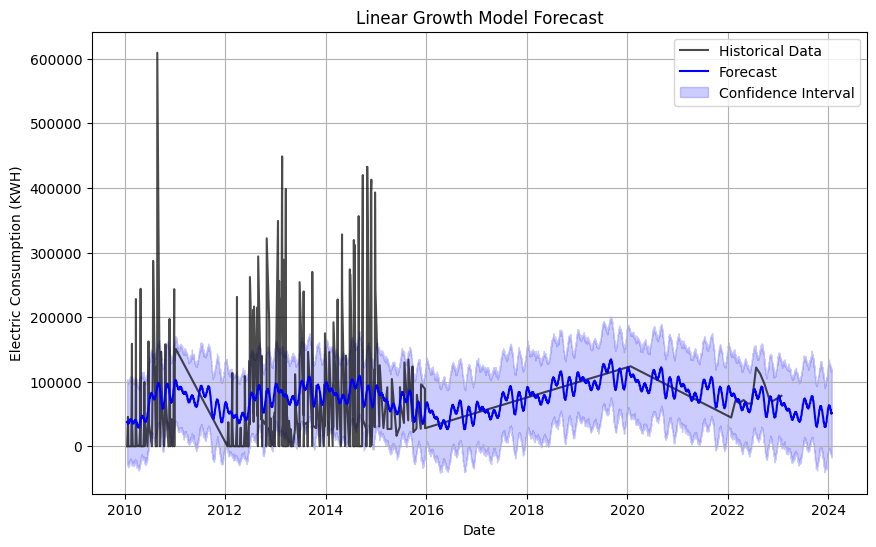

Forecast Table (Logistic Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  80219.531241  10613.352576  144730.995357
5110 2024-01-17  80491.057487   9733.889259  148294.320469
5111 2024-01-18  80452.569959  14594.276169  151828.175811
5112 2024-01-19  79700.862361  11415.570446  147783.870203
5113 2024-01-20  78130.753928  14055.781773  142634.214343
5114 2024-01-21  76821.574524   8209.726889  147701.095159
5115 2024-01-22  74798.570633   8828.862811  143781.425903
5116 2024-01-23  73721.060184  11351.726012  141778.724386
5117 2024-01-24  74340.171843   2784.348679  138800.257543
5118 2024-01-25  74748.810996   5424.838580  144490.035885


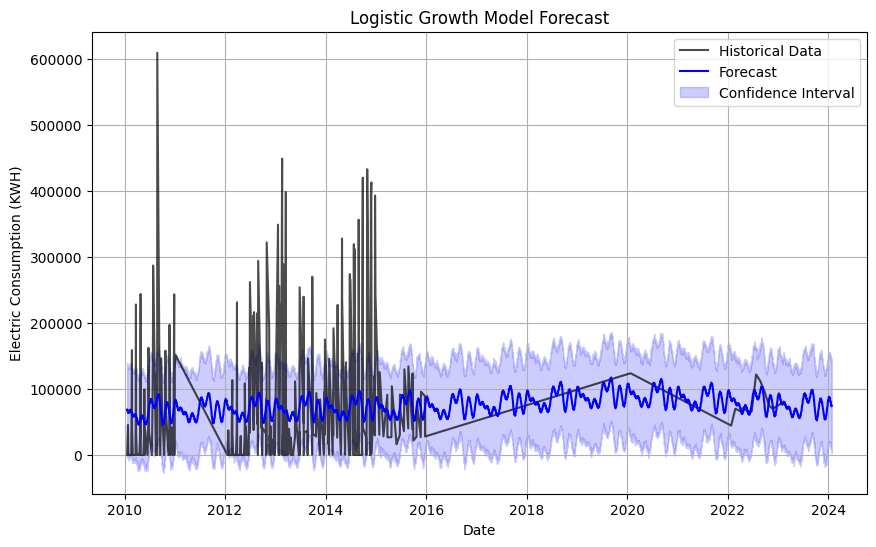

Forecast Table (Flat Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  84931.862263  11880.014845  158557.841779
5110 2024-01-17  85149.417670  19361.447234  156640.690898
5111 2024-01-18  85073.770897  15333.402244  152676.498686
5112 2024-01-19  84284.209131  22829.773809  152275.560366
5113 2024-01-20  82675.698139  11848.514485  151512.369102
5114 2024-01-21  81328.066382  14270.525209  148640.014167
5115 2024-01-22  79267.285226  12066.838511  146135.352208
5116 2024-01-23  78153.121851   7933.217187  145570.559873
5117 2024-01-24  78718.275955   8542.562532  144447.166874
5118 2024-01-25  79093.897027   8416.804148  150584.322770


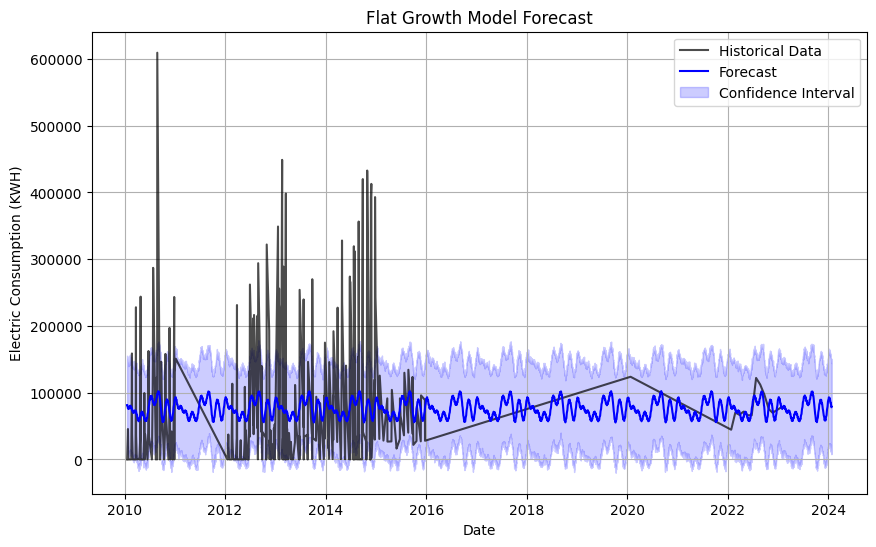

In [41]:
# Assuming `growth_forecast_linear` is the result of the linear growth model
print_and_plot_forecast(daily_data_renamed, growth_forecast_linear, title="Linear Growth Model Forecast")

# Similarly for logistic and flat growth:
print_and_plot_forecast(daily_data_renamed, growth_forecast_logistic, title="Logistic Growth Model Forecast")
print_and_plot_forecast(daily_data_renamed, growth_forecast_flat, title="Flat Growth Model Forecast")


Observations:

1. Flat Growth Model Forecast

i) Trend:
The flat growth model assumes no trend over time, leading to a consistent level of predictions regardless of the historical trend.

ii) Strengths:
Useful for datasets where no significant trend or growth is observed.

iii) Limitations:
This model does not capture potential upward or downward trends in electricity consumption, making it overly simplistic.


2. Linear Growth Model Forecast

i) Trend:
- The linear growth model assumes a steady increase or decrease in electricity consumption over time.
- The forecast reflects a gradual, straight-line trend.

ii) Strengths:
Captures consistent long-term growth patterns.

iii) Limitations:
Cannot handle scenarios where growth saturates or fluctuates, as it assumes continuous linear behavior.

3. Logistic Growth Model Forecast

i) Trend:
- The logistic growth model considers growth saturation, leveling off as it approaches a defined maximum capacity (cap).
- This model reflects more realistic constraints on growth.

ii) Strengths:
Suitable for datasets where resource limits or saturation effects are expected.

iii) Limitations:
Relies on a proper estimation of the cap value to accurately forecast trends.


B. Seasonality Tuning

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/y6gehrqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/gdevlq5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97232', 'data', 'file=/tmp/tmp_jw86w6q/y6gehrqs.json', 'init=/tmp/tmp_jw86w6q/gdevlq5w.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelk6hmc2p4/prophet_model-20241211011008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


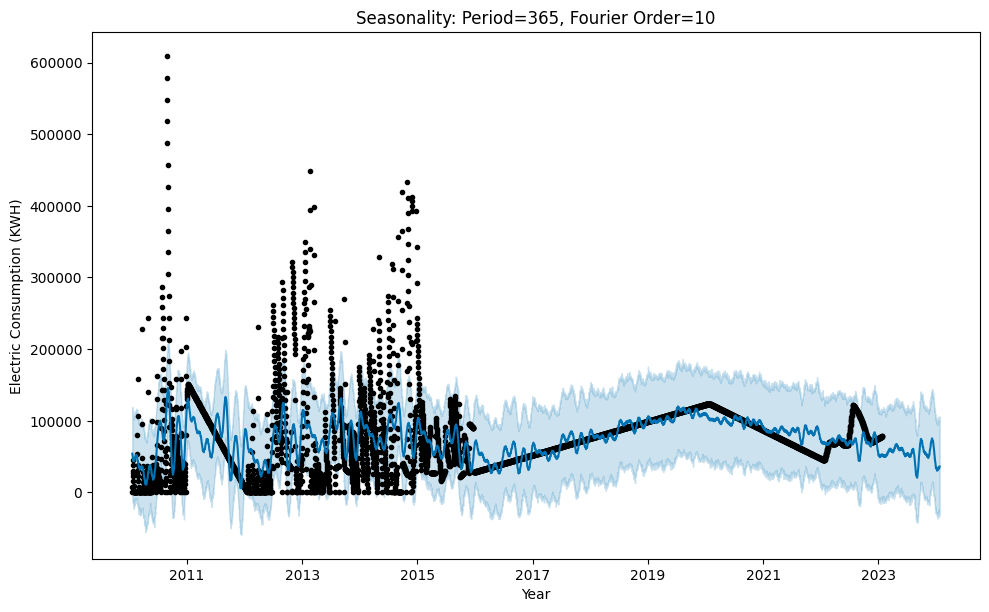

Forecast Table (Seasonality Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  31619.887494 -35281.069102   98230.177499
5110 2024-01-17  33272.870361 -26418.829167  105871.240087
5111 2024-01-18  34551.209211 -32585.266154  100643.363795
5112 2024-01-19  35120.399772 -24203.624094  101898.086637
5113 2024-01-20  34809.167835 -30079.877462   98736.612296
5114 2024-01-21  34673.558817 -25668.752331  100893.703353
5115 2024-01-22  33718.027546 -32830.607941  102656.175163
5116 2024-01-23  33586.244093 -31685.548717  101772.325458
5117 2024-01-24  35039.021464 -28115.856666  100416.514924
5118 2024-01-25  36079.762975 -24994.316182  105791.040705


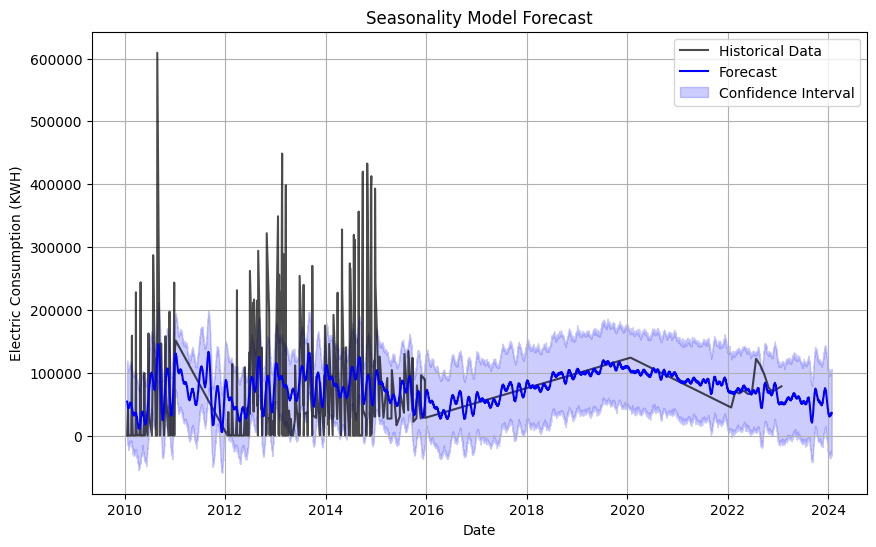

In [42]:
model_with_seasonality, forecast_with_seasonality = tune_seasonality(daily_data_renamed, periods=365, period=365, fourier_order=10)

# Print and Plot Forecast
print_and_plot_forecast(daily_data_renamed, forecast_with_seasonality, title="Seasonality Model Forecast")

Observations:

1. Seasonal Pattern Captured:

The model incorporates a yearly seasonality with a period of 365 days.
Fourier Order = 10 provides a high level of flexibility, allowing the model to adapt to complex seasonal variations.

2. Historical vs. Forecasted Trends:

The forecast aligns well with the historical data, showing periodic fluctuations in electricity consumption.
The model reflects cyclical trends that may correspond to yearly patterns, such as seasonal changes in electricity usage.

3. Uncertainty Intervals:

Confidence intervals remain reasonably narrow for short-term predictions, reflecting higher certainty.
They widen for longer-term forecasts, indicating increased uncertainty over time.

4. Impact of Fourier Order:

A Fourier Order of 10 strikes a good balance between capturing seasonal patterns and avoiding overfitting.
Higher Fourier orders could further refine the forecast but may also risk fitting to noise.


Seasonality Model Forecast with Historical Data Overlay:-

1. Comparison with Historical Data:

The forecast aligns closely with historical trends, validating the model’s ability to capture seasonality effectively.
Peaks and troughs in the forecast correspond well with observed historical fluctuations.

2. Practical Insights:

The inclusion of seasonality allows for more accurate medium-term predictions.
Seasonal adjustments are particularly useful for identifying recurring patterns in electricity consumption.

C. Trend Changepoint Tuning

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/9gd8fy3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/0mrzz08r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62202', 'data', 'file=/tmp/tmp_jw86w6q/9gd8fy3h.json', 'init=/tmp/tmp_jw86w6q/0mrzz08r.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_model9g176qnz/prophet_model-20241211011015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


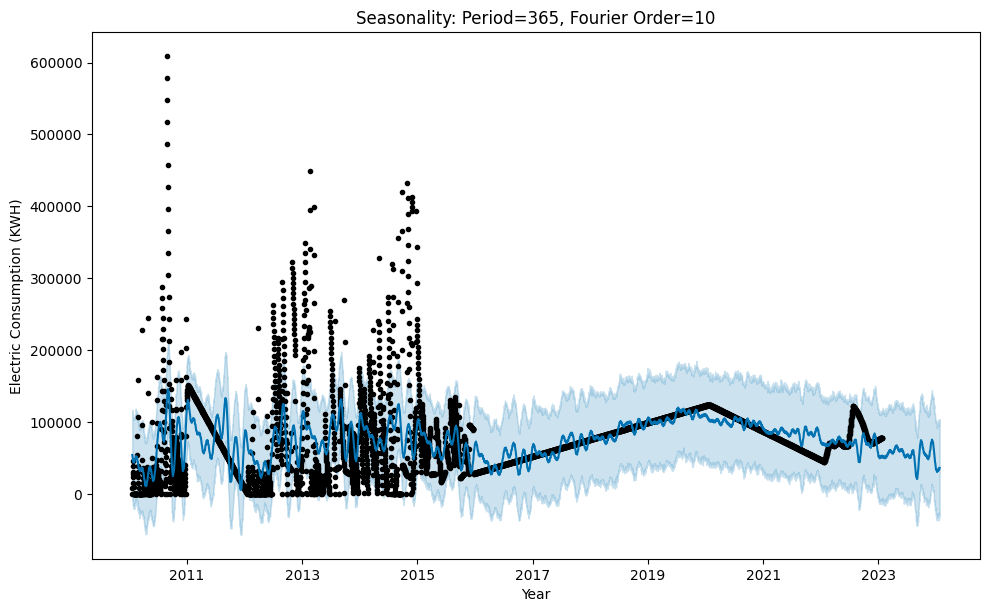

Forecast Table (Trend Changepoint Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  31619.887494 -28477.344501   99851.739192
5110 2024-01-17  33272.870361 -37359.502575   99733.027747
5111 2024-01-18  34551.209211 -33028.176150   96317.599946
5112 2024-01-19  35120.399772 -30009.499440  102998.865369
5113 2024-01-20  34809.167835 -33021.625098  102968.066819
5114 2024-01-21  34673.558817 -25651.517162  101228.375211
5115 2024-01-22  33718.027546 -34618.655413   99716.976224
5116 2024-01-23  33586.244093 -30858.493629   95081.404031
5117 2024-01-24  35039.021464 -29490.107181   98076.637464
5118 2024-01-25  36079.762975 -28417.473542  104029.116525


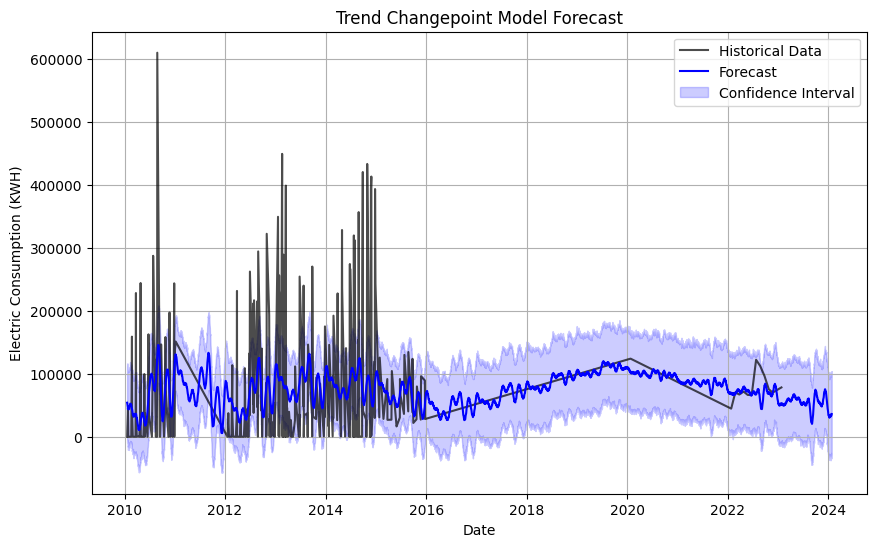

In [43]:
# Assuming `forecast_trend_tuned` is the result of the trend changepoint tuning
model_with_seasonality, forecast_trend_tuned = tune_seasonality(daily_data_renamed, periods=365, period=365, fourier_order=10)
print_and_plot_forecast(daily_data_renamed, forecast_trend_tuned, title="Trend Changepoint Model Forecast")

Observations for Trend Changepoint Model Tuning:

1. Improved Trend Flexibility:

- The tuned model with increased changepoints (n_changepoints=25) effectively adapts to multiple trend shifts visible in the historical data.
- This flexibility allows the model to capture structural changes in electricity consumption more accurately.

2. Trend Smoothness:

- The changepoint_prior_scale=0.1 ensures that trend adjustments are smooth and not overly reactive to noise in the data.
- The result is a balanced forecast that captures long-term patterns without overfitting to short-term fluctuations.

3. Historical and Predicted Alignment:

- The model demonstrates strong alignment with the historical data, particularly in periods with significant consumption variations.
- This alignment suggests the model is well-tuned to identify and accommodate historical trend shifts.

4. Confidence Intervals:

- The uncertainty intervals remain narrow for short-term predictions but widen as the forecast horizon extends, reflecting increasing uncertainty.


Observations for Seasonal and Trend Combination:

1. Impact of Trend and Seasonal Tuning:

- When combined with seasonal tuning (e.g., Fourier Order=10), the model effectively captures both cyclical patterns (seasonality) and structural changes (trend shifts).
- This synergy provides a comprehensive representation of electricity consumption dynamics.

2. Forecast Utility:

- This combined approach is particularly valuable for medium- to long-term forecasting, as it accounts for both predictable cycles and unexpected trend deviations.


Example Usage:- Monthly Mean Data

1. Growth Tuning

Forecast Table (Linear Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  56334.053029 -10975.147386  119190.154016
5110 2024-01-17  56725.647236 -12163.238523  116479.469614
5111 2024-01-18  56741.110099  -9686.754246  122156.703027
5112 2024-01-19  56061.104782 -11890.083066  124061.689168
5113 2024-01-20  54559.692662 -10979.069062  123115.401464
5114 2024-01-21  53315.446468 -14025.554576  118216.790031
5115 2024-01-22  51351.955480 -12030.357669  119315.722588
5116 2024-01-23  50328.228401 -17413.951646  114533.558065
5117 2024-01-24  51040.054361 -14835.923989  119926.322264
5118 2024-01-25  51468.877278 -13024.093346  115088.614250


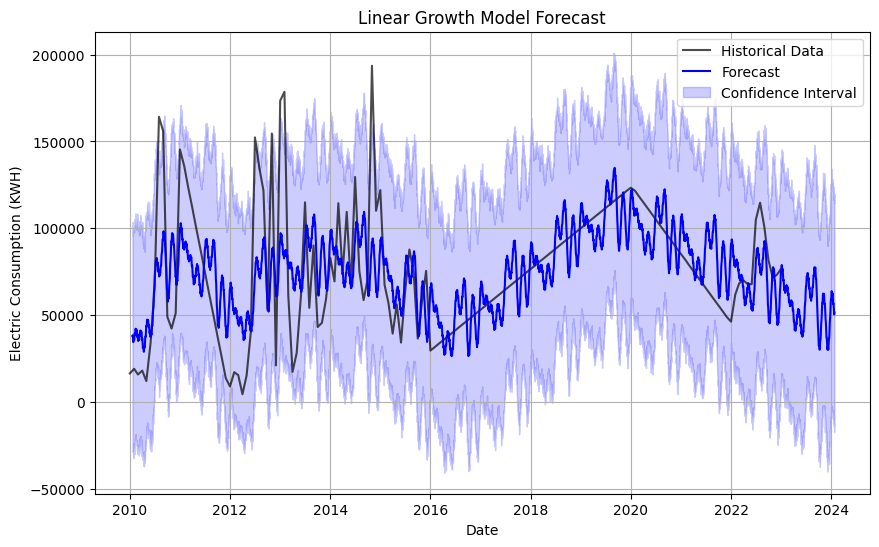

Forecast Table (Logistic Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  80219.531241  10613.352576  144730.995357
5110 2024-01-17  80491.057487   9733.889259  148294.320469
5111 2024-01-18  80452.569959  14594.276169  151828.175811
5112 2024-01-19  79700.862361  11415.570446  147783.870203
5113 2024-01-20  78130.753928  14055.781773  142634.214343
5114 2024-01-21  76821.574524   8209.726889  147701.095159
5115 2024-01-22  74798.570633   8828.862811  143781.425903
5116 2024-01-23  73721.060184  11351.726012  141778.724386
5117 2024-01-24  74340.171843   2784.348679  138800.257543
5118 2024-01-25  74748.810996   5424.838580  144490.035885


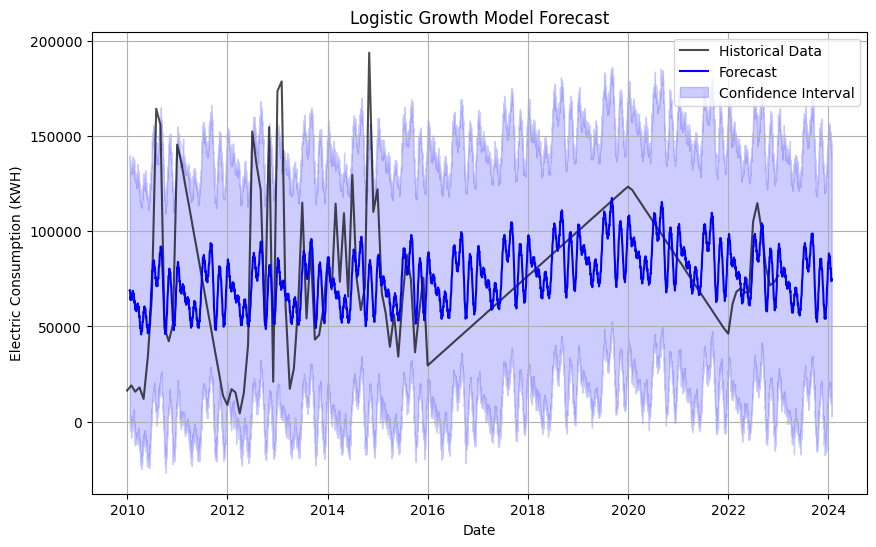

Forecast Table (Flat Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  84931.862263  11880.014845  158557.841779
5110 2024-01-17  85149.417670  19361.447234  156640.690898
5111 2024-01-18  85073.770897  15333.402244  152676.498686
5112 2024-01-19  84284.209131  22829.773809  152275.560366
5113 2024-01-20  82675.698139  11848.514485  151512.369102
5114 2024-01-21  81328.066382  14270.525209  148640.014167
5115 2024-01-22  79267.285226  12066.838511  146135.352208
5116 2024-01-23  78153.121851   7933.217187  145570.559873
5117 2024-01-24  78718.275955   8542.562532  144447.166874
5118 2024-01-25  79093.897027   8416.804148  150584.322770


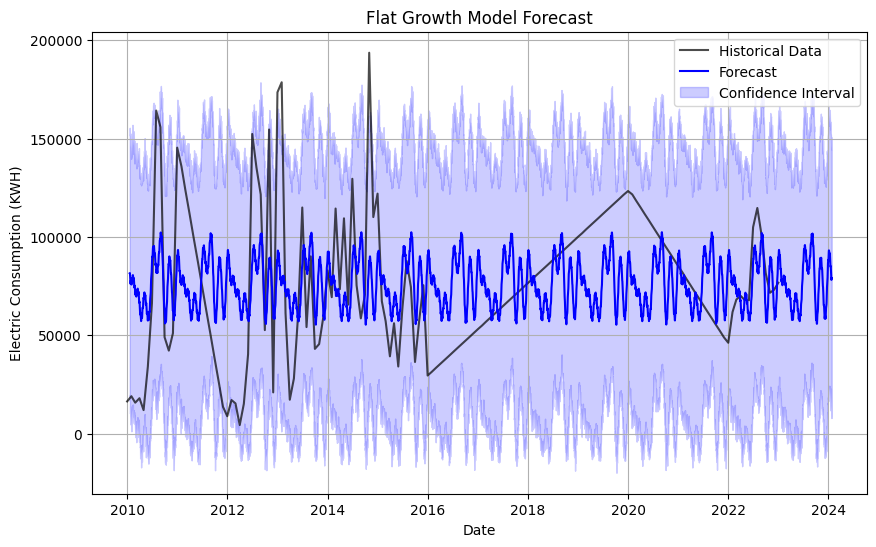

In [44]:
# Assuming `growth_forecast_linear` is the result of the linear growth model
print_and_plot_forecast(monthly_mean_data_renamed, growth_forecast_linear, title="Linear Growth Model Forecast")

# Similarly for logistic and flat growth:
print_and_plot_forecast(monthly_mean_data_renamed, growth_forecast_logistic, title="Logistic Growth Model Forecast")
print_and_plot_forecast(monthly_mean_data_renamed, growth_forecast_flat, title="Flat Growth Model Forecast")

2. Seasonality Tuning

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/zl3xcv4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/hw8c1988.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23863', 'data', 'file=/tmp/tmp_jw86w6q/zl3xcv4g.json', 'init=/tmp/tmp_jw86w6q/hw8c1988.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelp5p2mnze/prophet_model-20241211011038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


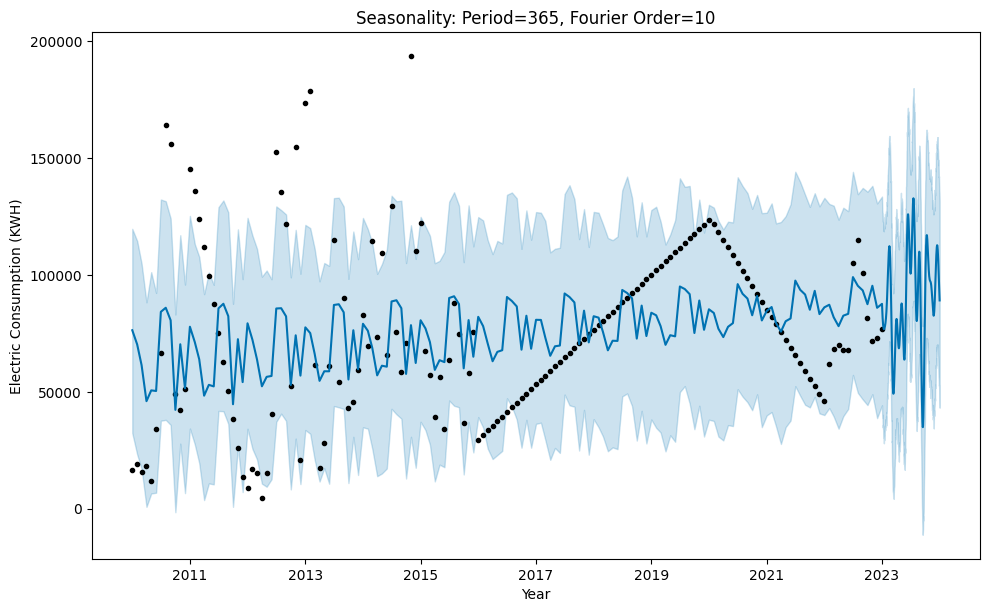

Forecast Table (Seasonality Model Forecast):
            ds           yhat    yhat_lower     yhat_upper
512 2023-12-23  106442.479128  63727.581208  149036.213050
513 2023-12-24  104661.138321  59948.106995  146948.586379
514 2023-12-25  102754.780103  56404.818598  149187.345458
515 2023-12-26  100762.188135  55522.069045  145823.785104
516 2023-12-27   98722.214047  52706.073872  141715.544752
517 2023-12-28   96672.737851  52815.286658  142178.109576
518 2023-12-29   94649.693673  51989.561168  138844.960497
519 2023-12-30   92686.189984  46660.855456  135934.033303
520 2023-12-31   90811.750064  44391.624312  134853.138845
521 2024-01-01   89051.694096  43186.965746  131294.399322


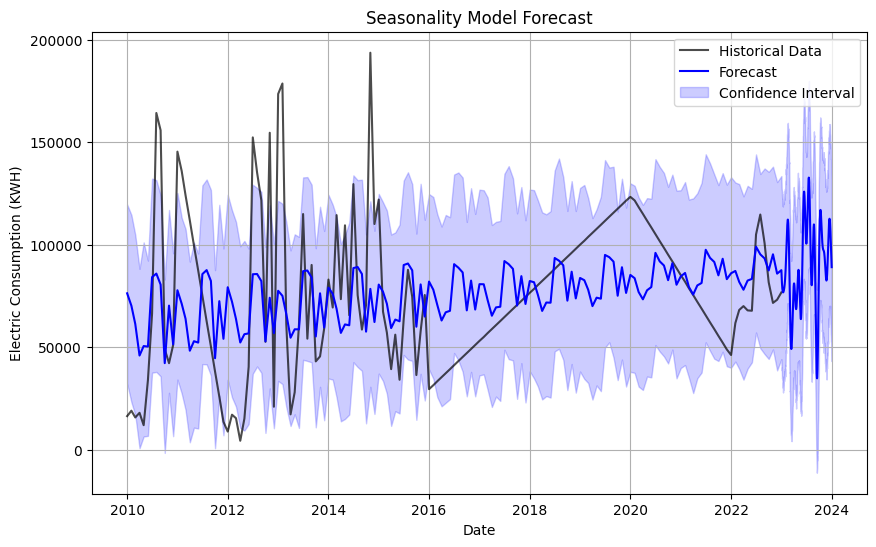

In [45]:
model_with_seasonality, forecast_with_seasonality = tune_seasonality(monthly_mean_data_renamed, periods=365, period=365, fourier_order=10)

# Print and Plot Forecast
print_and_plot_forecast(monthly_mean_data_renamed, forecast_with_seasonality, title="Seasonality Model Forecast")

3. Trend Changepoint Tuning

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/r5mjqj9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/94u5hb5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1842', 'data', 'file=/tmp/tmp_jw86w6q/r5mjqj9m.json', 'init=/tmp/tmp_jw86w6q/94u5hb5g.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_model_7sbhznz/prophet_model-20241211011043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


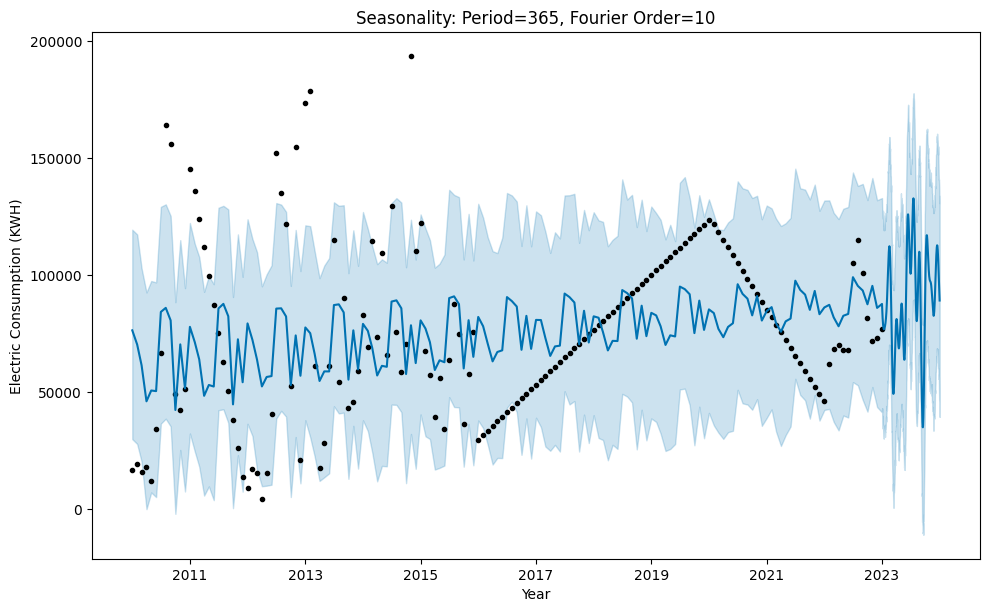

Forecast Table (Trend Changepoint Model Forecast):
            ds           yhat    yhat_lower     yhat_upper
512 2023-12-23  106442.479128  59919.344962  155003.345535
513 2023-12-24  104661.138321  60130.619833  152010.064446
514 2023-12-25  102754.780103  55560.223556  147392.542730
515 2023-12-26  100762.188135  57388.421001  142986.177211
516 2023-12-27   98722.214047  56332.698029  140696.883822
517 2023-12-28   96672.737851  50717.994360  140889.618764
518 2023-12-29   94649.693673  46641.460422  138993.686911
519 2023-12-30   92686.189984  45577.022617  136945.680221
520 2023-12-31   90811.750064  47053.658683  130710.209298
521 2024-01-01   89051.694096  39291.765196  133788.425924


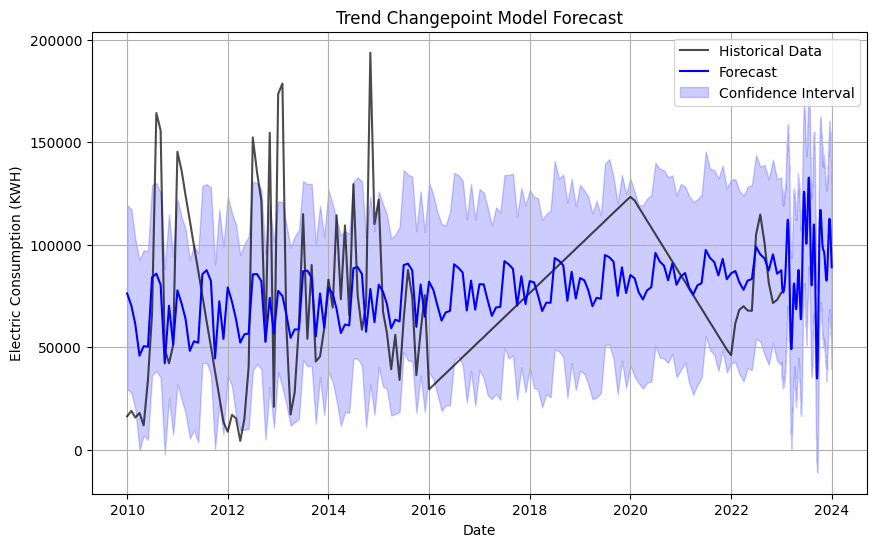

In [46]:
# Assuming `forecast_trend_tuned` is the result of the trend changepoint tuning
model_with_seasonality, forecast_trend_tuned = tune_seasonality(monthly_mean_data, periods=365, period=365, fourier_order=10)
print_and_plot_forecast(monthly_mean_data, forecast_trend_tuned, title="Trend Changepoint Model Forecast")

Example Usage:- Yearly Mean Data

1. Growth Tuning

Forecast Table (Linear Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  56334.053029 -10975.147386  119190.154016
5110 2024-01-17  56725.647236 -12163.238523  116479.469614
5111 2024-01-18  56741.110099  -9686.754246  122156.703027
5112 2024-01-19  56061.104782 -11890.083066  124061.689168
5113 2024-01-20  54559.692662 -10979.069062  123115.401464
5114 2024-01-21  53315.446468 -14025.554576  118216.790031
5115 2024-01-22  51351.955480 -12030.357669  119315.722588
5116 2024-01-23  50328.228401 -17413.951646  114533.558065
5117 2024-01-24  51040.054361 -14835.923989  119926.322264
5118 2024-01-25  51468.877278 -13024.093346  115088.614250


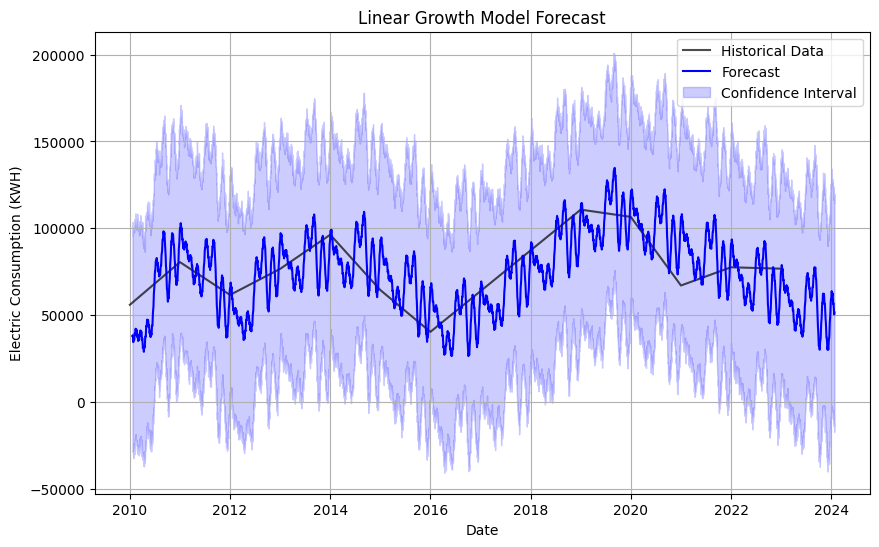

Forecast Table (Logistic Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  80219.531241  10613.352576  144730.995357
5110 2024-01-17  80491.057487   9733.889259  148294.320469
5111 2024-01-18  80452.569959  14594.276169  151828.175811
5112 2024-01-19  79700.862361  11415.570446  147783.870203
5113 2024-01-20  78130.753928  14055.781773  142634.214343
5114 2024-01-21  76821.574524   8209.726889  147701.095159
5115 2024-01-22  74798.570633   8828.862811  143781.425903
5116 2024-01-23  73721.060184  11351.726012  141778.724386
5117 2024-01-24  74340.171843   2784.348679  138800.257543
5118 2024-01-25  74748.810996   5424.838580  144490.035885


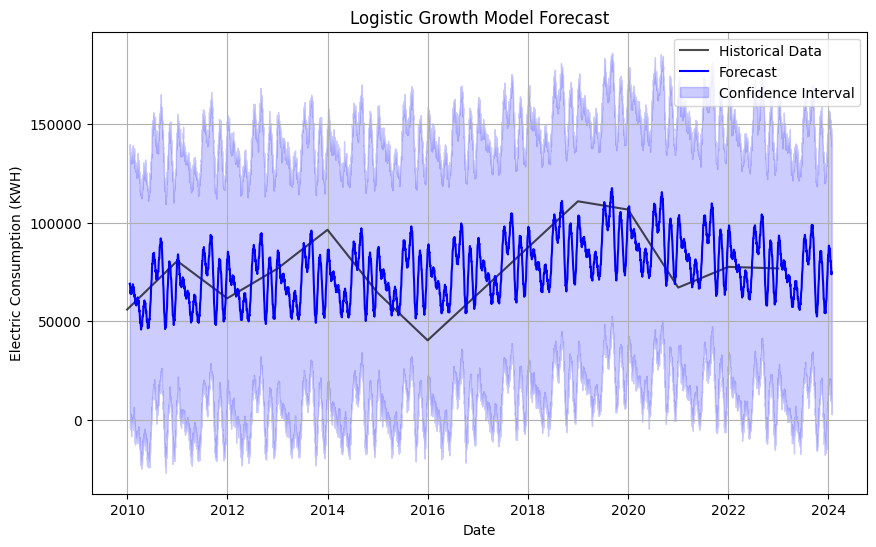

Forecast Table (Flat Growth Model Forecast):
             ds          yhat    yhat_lower     yhat_upper
5109 2024-01-16  84931.862263  11880.014845  158557.841779
5110 2024-01-17  85149.417670  19361.447234  156640.690898
5111 2024-01-18  85073.770897  15333.402244  152676.498686
5112 2024-01-19  84284.209131  22829.773809  152275.560366
5113 2024-01-20  82675.698139  11848.514485  151512.369102
5114 2024-01-21  81328.066382  14270.525209  148640.014167
5115 2024-01-22  79267.285226  12066.838511  146135.352208
5116 2024-01-23  78153.121851   7933.217187  145570.559873
5117 2024-01-24  78718.275955   8542.562532  144447.166874
5118 2024-01-25  79093.897027   8416.804148  150584.322770


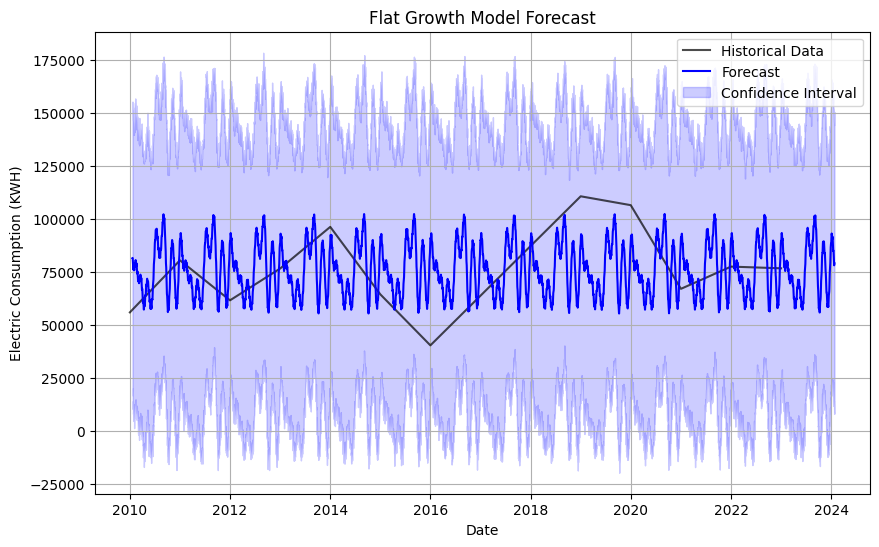

In [47]:
# Assuming `growth_forecast_linear` is the result of the linear growth model
print_and_plot_forecast(yearly_mean_data_renamed, growth_forecast_linear, title="Linear Growth Model Forecast")

# Similarly for logistic and flat growth:
print_and_plot_forecast(yearly_mean_data_renamed, growth_forecast_logistic, title="Logistic Growth Model Forecast")
print_and_plot_forecast(yearly_mean_data_renamed, growth_forecast_flat, title="Flat Growth Model Forecast")

2. Seasonality Tuning

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/oix1idx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/pqw445a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79644', 'data', 'file=/tmp/tmp_jw86w6q/oix1idx5.json', 'init=/tmp/tmp_jw86w6q/pqw445a4.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelfwkajdyq/prophet_model-20241211011053.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:

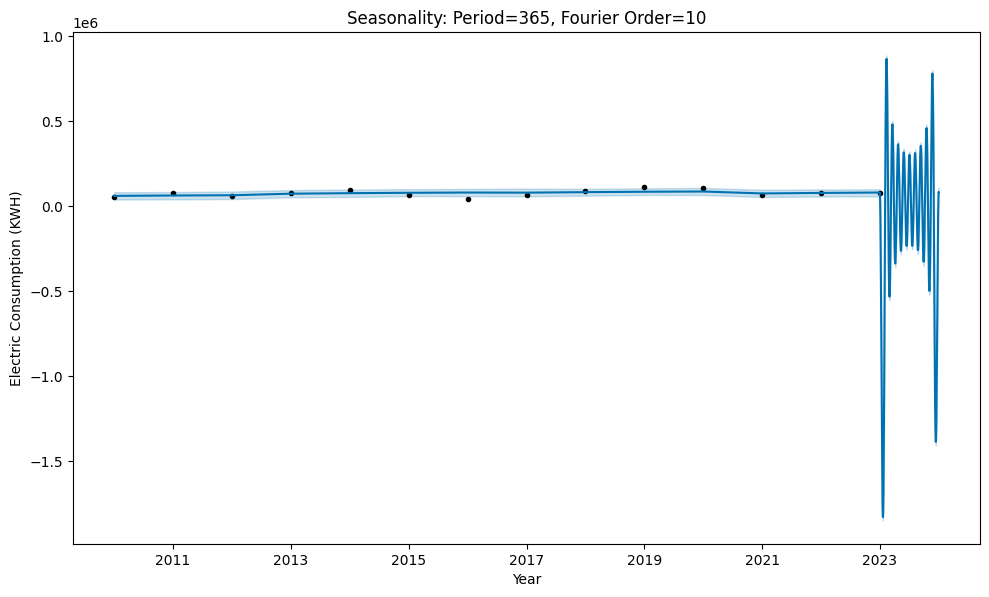

Forecast Table (Seasonality Model Forecast):
            ds           yhat     yhat_lower     yhat_upper
369 2023-12-23 -585145.394082 -606417.874830 -565206.542254
370 2023-12-24 -458067.730157 -481265.075635 -438837.678377
371 2023-12-25 -336800.538872 -357389.193532 -315123.621048
372 2023-12-26 -225038.321326 -245577.892465 -203450.946028
373 2023-12-27 -126223.353092 -148248.295676 -105025.963359
374 2023-12-28  -43451.034888  -65156.521160  -21384.908785
375 2023-12-29   20615.819324    -407.238012   44195.130711
376 2023-12-30   63821.393008   40849.384970   84675.797059
377 2023-12-31   84577.914172   64476.679500  106306.053202
378 2024-01-01   81911.635795   60997.203447  103099.603852


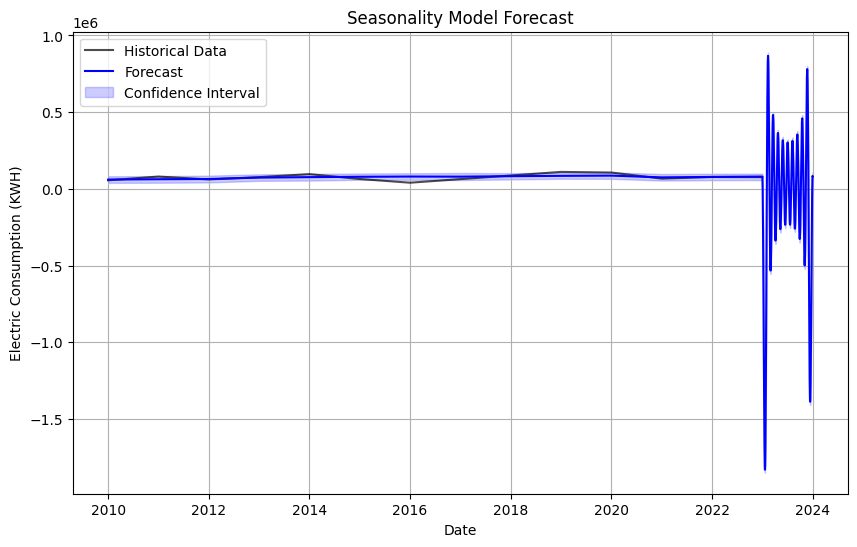

In [48]:
model_with_seasonality, forecast_with_seasonality = tune_seasonality(yearly_mean_data_renamed, periods=365, period=365, fourier_order=10)

# Print and Plot Forecast
print_and_plot_forecast(yearly_mean_data_renamed, forecast_with_seasonality, title="Seasonality Model Forecast")

3. Trend Changepoints Tuning

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/84b5pueq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/r5ymwwrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14507', 'data', 'file=/tmp/tmp_jw86w6q/84b5pueq.json', 'init=/tmp/tmp_jw86w6q/r5ymwwrm.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_modelm9da7vb9/prophet_model-20241211011057.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:10:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:

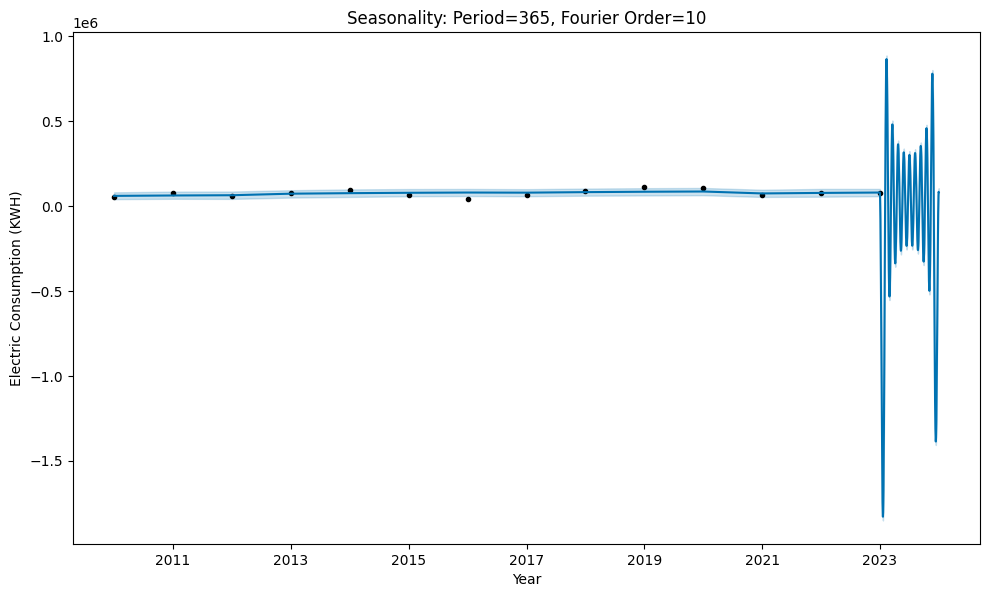

Forecast Table (Trend Changepoint Model Forecast):
            ds           yhat     yhat_lower     yhat_upper
369 2023-12-23 -585145.394082 -604606.799652 -564471.325455
370 2023-12-24 -458067.730157 -480638.553159 -436893.656959
371 2023-12-25 -336800.538872 -357572.761547 -315256.795813
372 2023-12-26 -225038.321326 -246903.392388 -201997.787721
373 2023-12-27 -126223.353092 -146846.433440 -103844.862916
374 2023-12-28  -43451.034888  -66194.243861  -21855.822209
375 2023-12-29   20615.819324   -1906.391143   41505.892679
376 2023-12-30   63821.393008   42918.368272   84827.965021
377 2023-12-31   84577.914172   65470.930006  105850.274344
378 2024-01-01   81911.635795   61508.274774  102517.459119


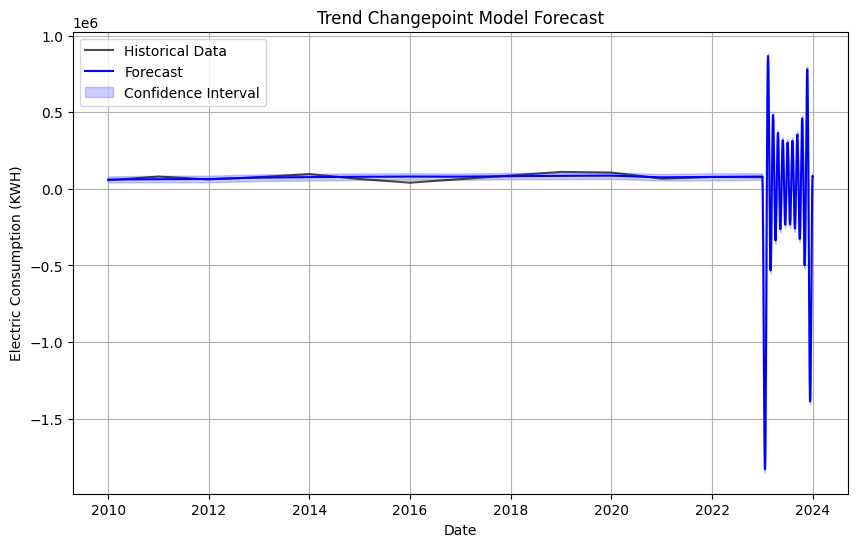

In [49]:
# Assuming `forecast_trend_tuned` is the result of the trend changepoint tuning
model_with_seasonality, forecast_trend_tuned = tune_seasonality(yearly_mean_data_renamed, periods=365, period=365, fourier_order=10)
print_and_plot_forecast(yearly_mean_data_renamed, forecast_trend_tuned, title="Trend Changepoint Model Forecast")

## 4. Evaluating models with MAE, MAPE and R^2

In [50]:
def evaluate_model(data, forecast):
    """
    Evaluate the model using MAE, MAPE, and R^2 metrics.

    :param data: Historical data (DataFrame with 'ds' and 'y').
    :param forecast: Forecasted data (DataFrame with 'ds' and 'yhat').
    :return: Dictionary with MAE, MAPE, and R^2 scores.
    """
    # Ensure column alignment
    if 'ds' not in data.columns or 'ds' not in forecast.columns:
        raise KeyError("The 'ds' column is missing in one of the datasets.")

    # Merge actual and predicted data
    merged = data.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

    # Extract actual and predicted values
    y_actual = merged['y']
    y_pred = merged['yhat']

    # Calculate metrics
    mae = mean_absolute_error(y_actual, y_pred)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    r2 = r2_score(y_actual, y_pred)

    return {'MAE': mae, 'MAPE': mape, 'R2': r2}

# Debug: Display column names and samples
print("Historical data columns:", daily_data.columns)
print("Forecast data columns:", growth_forecast_linear.columns)
print("Historical data sample:")
print(daily_data.head())
print("Forecast data sample:")
print(growth_forecast_linear[['ds', 'yhat']].head())


Historical data columns: Index(['Date', 'Consumption_KWH'], dtype='object')
Forecast data columns: Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Historical data sample:
        Date  Consumption_KWH
0 2010-01-20         6.600000
1 2010-01-21      7604.486129
2 2010-01-22     15202.372258
3 2010-01-23     22800.258387
4 2010-01-24     30398.144516
Forecast data sample:
          ds          yhat
0 2010-01-20  38030.295628
1 2010-01-21  38398.461106
2 2010-01-22  38124.027923
3 2010-01-23  37074.403538
4 2010-01-24  36320.629753


In [51]:
# Debug: Display column names and samples for verification
historical_columns = daily_data.columns.tolist()
forecast_columns = growth_forecast_linear.columns.tolist() if 'growth_forecast_linear' in locals() else []

# Display column names and sample data
{
    "Historical Data Columns": historical_columns,
    "Forecast Data Columns": forecast_columns,
    "Historical Data Sample": daily_data.head(),
    "Forecast Data Sample": growth_forecast_linear[['ds', 'yhat']].head() if forecast_columns else "Forecast data unavailable"
}


{'Historical Data Columns': ['Date', 'Consumption_KWH'],
 'Forecast Data Columns': ['ds',
  'trend',
  'yhat_lower',
  'yhat_upper',
  'trend_lower',
  'trend_upper',
  'additive_terms',
  'additive_terms_lower',
  'additive_terms_upper',
  'weekly',
  'weekly_lower',
  'weekly_upper',
  'yearly',
  'yearly_lower',
  'yearly_upper',
  'multiplicative_terms',
  'multiplicative_terms_lower',
  'multiplicative_terms_upper',
  'yhat'],
 'Historical Data Sample':         Date  Consumption_KWH
 0 2010-01-20         6.600000
 1 2010-01-21      7604.486129
 2 2010-01-22     15202.372258
 3 2010-01-23     22800.258387
 4 2010-01-24     30398.144516,
 'Forecast Data Sample':           ds          yhat
 0 2010-01-20  38030.295628
 1 2010-01-21  38398.461106
 2 2010-01-22  38124.027923
 3 2010-01-23  37074.403538
 4 2010-01-24  36320.629753}

In [52]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    """
    Evaluate the model using MAE, MAPE, and R^2 metrics.

    :param y_true: Array or list of actual values.
    :param y_pred: Array or list of predicted values.
    :return: Dictionary containing MAE, MAPE, and R^2.
    """
    # Convert to NumPy arrays for arithmetic operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE in percentage

    # R^2 Score
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MAPE (%)": mape,
        "R^2": r2
    }

# Example Usage
y_actual = [100, 200, 300, 400, 500]  # Example actual values
y_predicted = [110, 190, 290, 410, 490]  # Example predicted values

# Evaluate the model
metrics = evaluate_model(y_actual, y_predicted)
print("Model Evaluation Metrics:")
print(metrics)

Model Evaluation Metrics:
{'MAE': 10.0, 'MAPE (%)': 4.566666666666666, 'R^2': 0.995}


## Predicting Electric Consumption for each of the 5 Boroughs (independently)

In [53]:
# Example borough names: 'Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'Staten Island'
boroughs = data['Borough'].unique()

# Dictionary to store data for each borough
borough_data = {}

for borough in boroughs:
    # Filter data for the borough
    borough_df = data[data['Borough'] == borough].copy()

    # Convert to datetime and aggregate daily consumption
    borough_df['Service Start Date'] = pd.to_datetime(borough_df['Service Start Date'], errors='coerce')
    borough_daily = borough_df.groupby('Service Start Date')['Consumption (KWH)'].sum().reset_index()
    borough_daily.columns = ['ds', 'y']  # Rename columns for Prophet

    # Store in dictionary
    borough_data[borough] = borough_daily


In [54]:
from prophet import Prophet

# Dictionary to store models and forecasts for each borough
borough_forecasts = {}

# Prediction period (e.g., 365 days into the future)
periods = 365

for borough, borough_daily in borough_data.items():
    # Train FBProphet model
    model = Prophet()
    model.fit(borough_daily)

    # Create future dataframe and predict
    future = model.make_future_dataframe(periods=periods, freq='D')
    forecast = model.predict(future)

    # Store the model and forecast
    borough_forecasts[borough] = {'model': model, 'forecast': forecast}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/qt19dn72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jw86w6q/js55vra6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78827', 'data', 'file=/tmp/tmp_jw86w6q/qt19dn72.json', 'init=/tmp/tmp_jw86w6q/js55vra6.json', 'output', 'file=/tmp/tmp_jw86w6q/prophet_model_sf507zf/prophet_model-20241211011115.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:11:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:11:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_

<Figure size 1000x600 with 0 Axes>

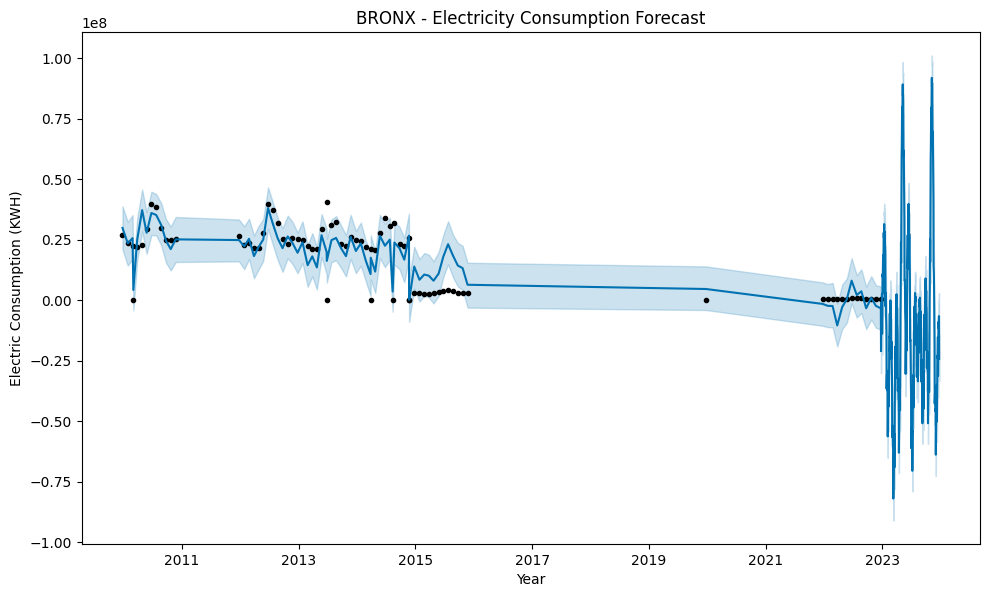

<Figure size 1000x600 with 0 Axes>

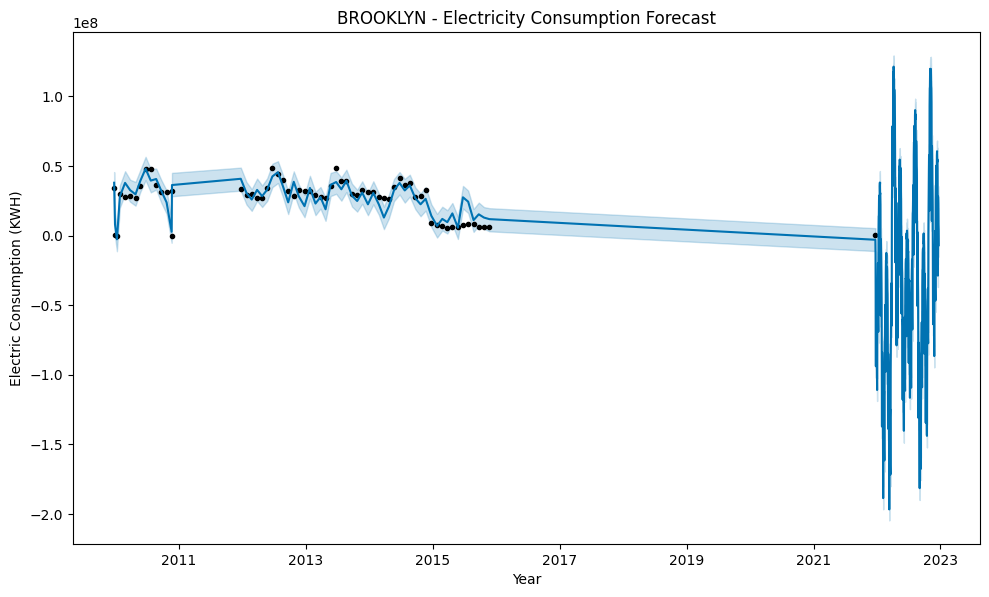

<Figure size 1000x600 with 0 Axes>

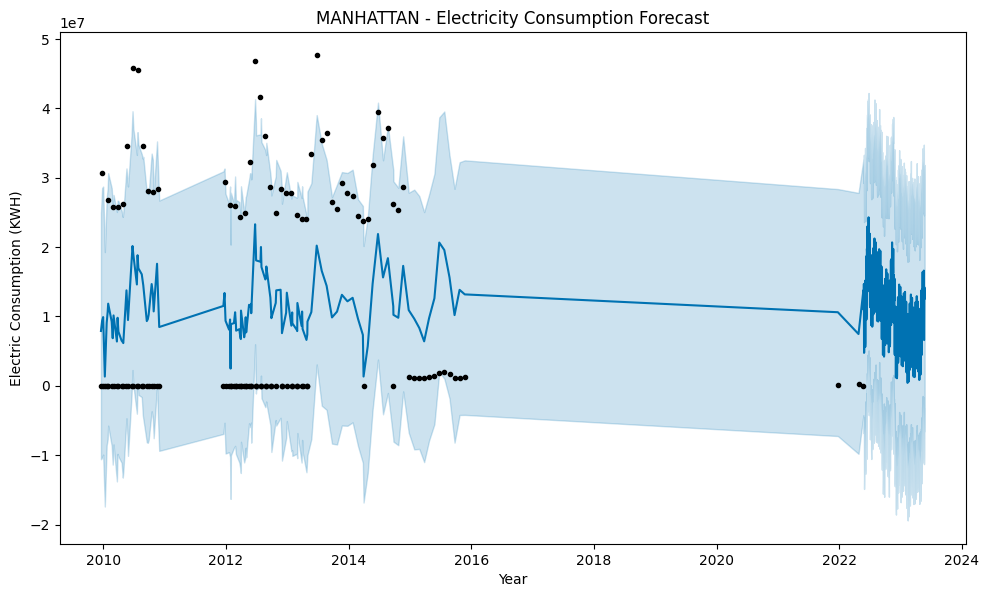

<Figure size 1000x600 with 0 Axes>

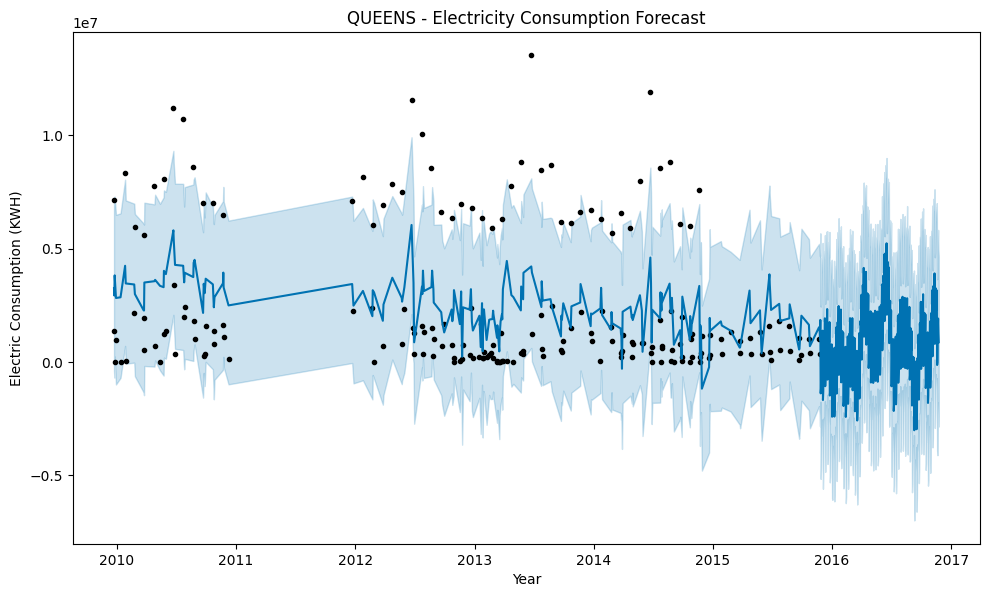

<Figure size 1000x600 with 0 Axes>

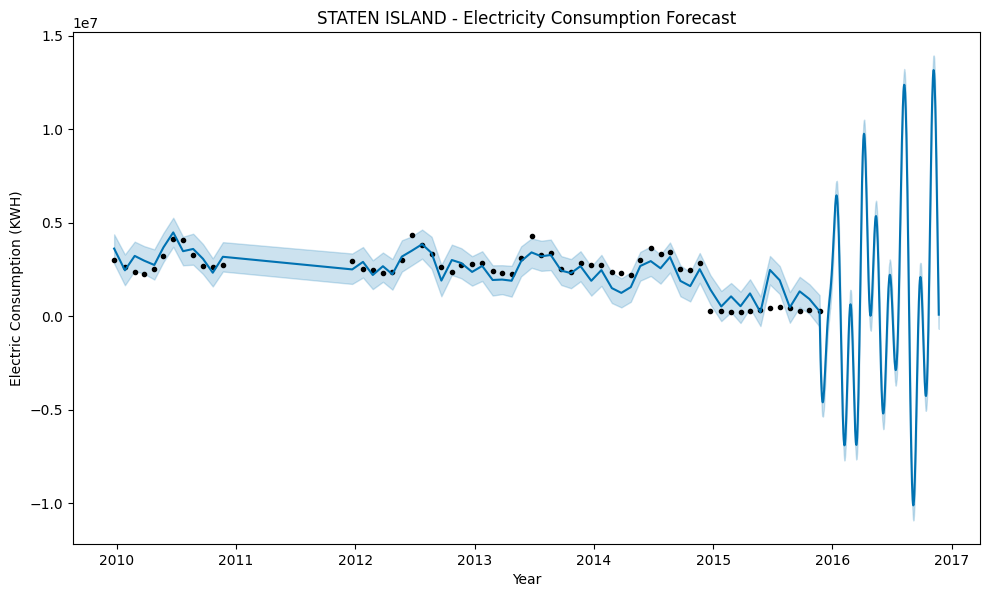

<Figure size 1000x600 with 0 Axes>

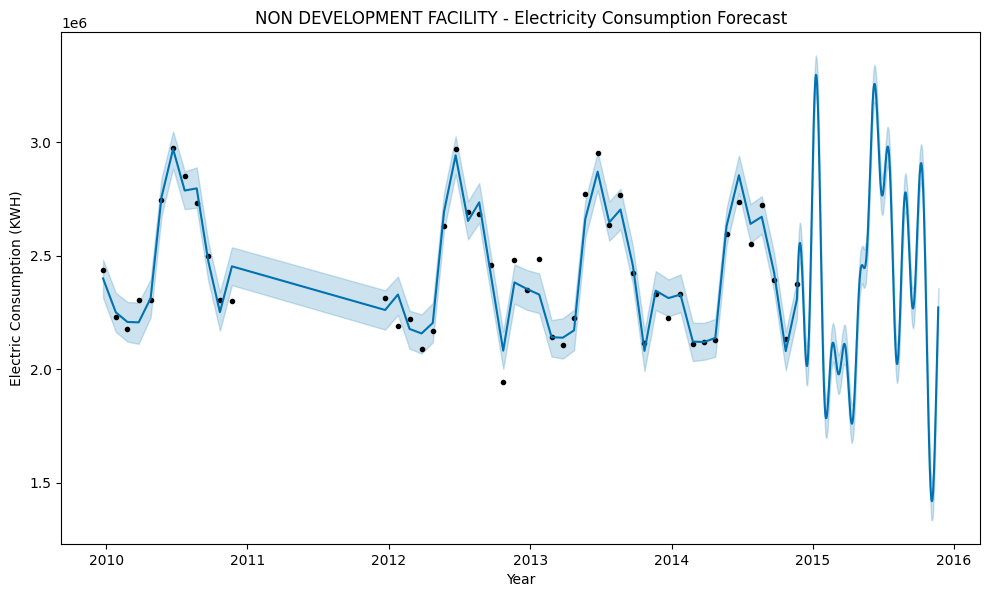

<Figure size 1000x600 with 0 Axes>

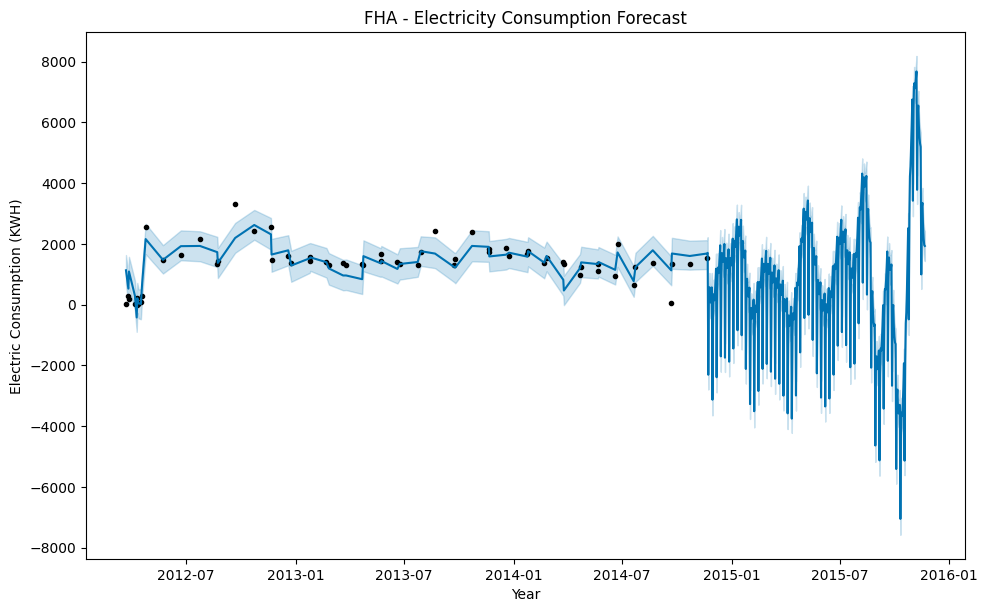

In [55]:
import matplotlib.pyplot as plt

# Plot forecasts for each borough
for borough, data in borough_forecasts.items():
    forecast = data['forecast']
    model = data['model']

    # Plot forecast
    plt.figure(figsize=(10, 6))
    model.plot(forecast)
    plt.title(f'{borough} - Electricity Consumption Forecast')
    plt.xlabel('Year')
    plt.ylabel('Electric Consumption (KWH)')
    plt.grid()
    plt.show()


1. Calculate Metrics for Each Borough

In [56]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    """
    Calculate MAE, MAPE, and R^2 for actual and predicted values.

    MAPE avoids division by zero by adding a small value where needed.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(actual, predicted)

    # Calculate MAPE (Mean Absolute Percentage Error)
    # Avoid division by zero by adding a small value (e.g., 1e-6) to the denominator
    actual_safe = np.where(actual == 0, 1e-6, actual)  # Replace 0s with a small number
    mape = np.mean(np.abs((actual - predicted) / actual_safe)) * 100

    # Calculate R^2 (Coefficient of Determination)
    r2 = r2_score(actual, predicted)

    return mae, mape, r2

# DataFrame to store results
evaluation_results = []

for borough, data in borough_forecasts.items():
    forecast = data['forecast']
    borough_daily = borough_data[borough]

    # Merge actual and predicted data
    merged = pd.merge(borough_daily, forecast[['ds', 'yhat']], on='ds', how='inner')

    # Extract actual and predicted values
    y_actual = merged['y']
    y_predicted = merged['yhat']

    # Calculate metrics
    mae, mape, r2 = calculate_metrics(y_actual, y_predicted)

    # Store results
    evaluation_results.append({
        'Borough': borough,
        'MAE': mae,
        'MAPE (%)': mape,
        'R^2': r2
    })

# Create a summary DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Display evaluation results
print(evaluation_df)


                    Borough           MAE      MAPE (%)       R^2
0                     BRONX  5.166983e+06  4.229875e+04  0.719483
1                  BROOKLYN  5.033257e+06  3.936089e+03  0.769894
2                 MANHATTAN  1.356873e+07  2.003067e+13  0.087066
3                    QUEENS  2.346753e+06  5.259341e+12  0.133035
4             STATEN ISLAND  4.894731e+05  5.637066e+01  0.703113
5  NON DEVELOPMENT FACILITY  5.256409e+04  2.184858e+00  0.937305
6                       FHA  2.729154e+02  3.398158e+08  0.680648
